## Modules

In [1]:
import numpy as np 
import math
import peakutils
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from scipy.integrate import odeint 
import scipy.signal as signal 
from scipy.spatial import KDTree


import pickle 
from numpy import random
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  
import os 
import os.path 

from SALib.sample import saltelli, fast_sampler, latin
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris, delta
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms

import glob 
from pathlib import Path
import shutil
from numba import njit, typed
import subprocess
import stat
import sys


## Oscillator class

In [3]:
'''
The deterministic model of biological oscillator
''' 
#@experimental.jitclass
class Oscillator: 
	def __init__(self, parameter_values, params, initial_conditions, dt = 0.1, mode = 1, sigma = 0.001, volume = 0.5): 
		self.nParams = len(params)   
		self.params = params #model parameters
		self.parameter_values = parameter_values #allowed parameter ranges  
		self.y0 = initial_conditions 
		self.volume = volume
		self.copynumbers = [self.copynumber(x) for x in self.y0]	
		self.dt = dt
		self.sigma = sigma
		self.T = 100 
		self.N = int(self.T/self.dt) 
		self.ts = np.linspace(0, self.T, self.N) 
		self.amp = 300 #[nM] 		
		self.per = self.T/8 	
		self.sample_rate 		= 0.0033333333 #Hz 
		self.samples_per_hour 	= (1/self.dt)		
		self.jump 				= int(self.samples_per_hour/(self.sample_rate*3600)) if int(self.samples_per_hour/(self.sample_rate*3600)) else 1 	 	
		self.ideal = self.amp*(np.sin(math.pi*(self.ts)/self.per - math.pi/2) + 1) 
		#number of samples for FFT		
		self.nS = self.N/self.jump 
		self.dF = self.sample_rate/self.nS  
		self.idealF = self.getFrequencies(self.ideal) 
		self.idealFreq = 0.3 #peaks per second 	
		self.penalty = 0.5 	
		thresholdOne = -(self.nS/2)*100 #10nM -+ from ideal signal harmonics       
		thresholdTwo = 0.1
		#self.maxFreq = 0.5
		#self.maxPeaks = self.maxFreq * self.T  
		self.minAmp = 1
		self.maxAmp = 6000 
		self.mode = mode    			
		self.modes = [self.eval]       
		self.threshold = thresholdOne  
		self.omega = 1000 #nm^-1 
		if self.mode == 1:
			self.threshold = thresholdTwo
	
	#gets summed difference of arrayData
	@staticmethod 	
	def getDif(indexes, arrayData):	
		arrLen = len(indexes)
		sum = 0
		for i, ind in enumerate(indexes):
			if i == arrLen - 1:
				break
			sum += arrayData[ind] - arrayData[indexes[i + 1]]
			
		#add last peak - same as substracting it from zero 
		sum += arrayData[indexes[-1:]]  
		return sum   
		
	#gets standard deviation 
	@staticmethod 
	def getSTD(indexes, arrayData, window):
		numPeaks = len(indexes)
		arrLen = len(arrayData)
		sum = 0
		for ind in indexes:
			minInd = max(0, ind - window)
			maxInd = min(arrLen, ind + window)
			sum += np.std(arrayData[minInd:maxInd])  
			
		sum = sum/numPeaks 	
		return sum	 
	
	def getFrequencies(self, y):
		#fft sample rate: 1 sample per 5 minutes
		y = y[0::self.jump]  
		res = abs(fft.rfft(y))
		#normalize the amplitudes 
		res = res/math.ceil(self.nS/2) 
		return res

	def costOne(self, Y): 
		p1 = Y[:,1]   
		fftData = self.getFrequencies(p1)     
		
		diff = fftData - self.idealF         
		cost = -np.dot(diff, diff) 		
		return cost,	
		
	def costTwo(self, Y, getAmplitude = False): 
		p1 = Y[:,13] 
		fftData = self.getFrequencies(p1)      
		fftData = np.array(fftData) 
		
		#find peaks using very low threshold and minimum distance
		#indexes = peakutils.indexes(fftData, thres=0.02/max(fftData), min_dist=1) 
		#find number of peaks in time domain for frequency threshold
		#peaknumber = len(peakutils.indexes(p1, thres=0.02/max(fftData), min_dist=1))  

		indexes = peakutils.indexes(fftData, thres=np.mean(fftData), min_dist=10, thres_abs = True) 
		#find number of peaks in time domain for frequency threshold
		peaknumber = len(peakutils.indexes(p1, thres=np.mean(p1), min_dist=1, thres_abs = True)) 

		#in case of no oscillations return 0 
		if len(indexes) == 0 or peaknumber == 0:
			return 0 , 0 
		#if amplitude is greater than 400nM
		amp = np.max(fftData[indexes])
		if amp > self.maxAmp: 
			return 0 ,0 
		fitSamples = fftData[indexes]  			
		std = self.getSTD(indexes, fftData, 1)  
		diff = self.getDif(indexes, fftData)  
		penalty =  ((abs(self.idealFreq - (peaknumber/self.T)))*self.penalty)
		cost = std + diff #- penalty #penalize difference from ideal frequency
		#print(cost)   
		if getAmplitude:
			return cost, amp
		return cost#, penalty
		
	def isViableFitness(self, fit):
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.eval(point, getAmplitude=True)  
		if self.mode == 0:
			return self.isViableFitness(fitness[0]) 
			
		fit = fitness[0] 
		amp = 0
		if fit > 0:
			amp = fitness[1] 
		return self.isViableFitness(fit) #and amp >= self.minAmp and amp <= self.maxAmp   


		
	#evaluates a candidate  
	def eval(self, candidate, getAmplitude = False): 
		Y = np.array(self.simulate(candidate)) 
		if self.mode == 0:
			return self.costOne(Y)  
		else:
			return self.costTwo(Y, getAmplitude=True)   #False before 7-26  

	
	#simulates a candidate
	def simulate(self, candidate):
		# y0 =  [candidate[0],candidate[1],candidate[2],candidate[3],0,candidate[4],0,0,0,0,0,0]
		return odeint(self.oscillatorModelOde, self.y0, self.ts, args=(typed.List(candidate),))   	

		

	def plotModel(self, subject, mode="ode", show=True):     		
		if mode == "ode":
			t = np.linspace(0, self.T, self.N)
			solutions = self.simulate(subject) 			
		else:
			#ssa simulation
			# can = self.full_converter(subject, True)
			t,solutions = self.ssa(subject)
			
		fig = plt.figure(figsize=(8,4),dpi=200)

		plt.plot(t,solutions[:,0], color="b", label = 'PIP')
		plt.plot(t,solutions[:,1], color="orange", label = 'PIP2')
		#plt.plot(t,solutions[:,2], color="gold", label = 'K')
		#plt.plot(t,solutions[:,3], color="r", label = 'P')
		#plt.plot(t,solutions[:,4], color="cyan", label = 'LK')
		plt.plot(t,solutions[:,5], color="r", label = 'AP2')
		plt.plot(t,solutions[:,6], color="g", label = 'PIP2-AP2')
		#plt.plot(t,solutions[:,7], color="yellow", label = 'LpAK')
		#plt.plot(t,solutions[:,8], color="magenta", label = 'LpAP')
		#plt.plot(t,solutions[:,9], color="deeppink", label = 'LpAPLp')
		#plt.plot(t,solutions[:,10], color="peru", label = 'LpAKL')
		#plt.plot(t,solutions[:,11], color="purple", label = 'LpP')
		plt.plot(t,solutions[:,12], color = "cyan", label = 'PIP2-AP2-TfR')


		plt.xlabel('Time (s)')
		plt.ylabel('Concentration (uM)')
		plt.legend(loc = 'upper right', bbox_to_anchor = (1.2,1)) #prop={'size': 6}
		plt.show()
			 				
	def getTotalVolume(self):
		vol = 1.0
		for param in self.params:		
			vol = vol*(self.parameter_values[param]["max"] - self.parameter_values[param]["min"])
		return vol 

	@staticmethod
	@njit
	def oscillatorModelOde(Y, t, can): 

		VA = can[12]
		
		sigma = 0.001

		ka1 = can[0]
		kb1 = can[1]
		kcat1 = can[2]

		ka2 = can[3]
		kb2 = can[4]

		ka3 = can[5]
		kb3 = can[6]

		ka4 = can[7]
		kb4 = can[8]

		ka7 = can[9]
		kb7 = can[10]
		kcat7 = can[11]

		ka5 = can[9]
		kb5 = can[10]
		kcat5 = can[11]

		ka6 = can[0]
		kb6 = can[1]
		kcat6 = can[2]

		ka8 = can[13]
		kb8 = can[14]

		#initial conditions
		L = Y[0]   # make sure in uM
		Lp = Y[1]
		K = Y[2]
		P = Y[3]
		LK = Y[4] 
		A = Y[5]
		LpA = Y[6] 
		LpAK = Y[7] 
		LpAP = Y[8] 
		LpAPLp = Y[9] 
		LpAKL = Y[10] 
		LpP = Y[11] 

		T = Y[12]
		LpAT = Y[13]

		dL = (kb1*LK) - (ka1*L*K) + (kcat5*LpAPLp) + (kb6*LpAKL) - ((VA/(sigma))*ka6*LpAK*L) + (kcat7*LpP)
		dLp = (kcat1*LK) + (kb2*LpA) - (ka2*Lp*A) + (kb5*LpAPLp) - ((VA/(sigma))*ka5*Lp*LpAP) + (kcat6*LpAKL) - (ka7*Lp*P) + (kb7*LpP)
		dK = (kb1*LK) - (ka1*L*K) + (kcat1*LK) + (kb3*LpAK) - (ka3*LpA*K)
		dP = (kb4*LpAP) - (ka4*LpA*P) - (ka7*Lp*P) + (kb7*LpP) + (kcat7*LpP)
		dLK = (ka1*L*K) - (kb1*LK) - (kcat1*LK)
		dA = (kb2*LpA) - (ka2*Lp*A)
		dLpA = (ka2*Lp*A) - (kb2*LpA) + (kb3*LpAK) - (ka3*LpA*K) + (kb4*LpAP) - (ka4*LpA*P) - (ka8*LpA*T) + (kb8*LpAT)
		dLpAK = (ka3*LpA*K) - (kb3*LpAK) + (kb6*LpAKL) - ((VA/(sigma))*ka6*LpAK*L) + (kcat6*LpAKL)
		dLpAP = (ka4*LpA*P) - (kb4*LpAP) + (kb5*LpAPLp) - ((VA/(sigma))*ka5*LpAP*Lp) + (kcat5*LpAPLp)
		dLpAPLp = ((VA/(sigma))*ka5*LpAP*Lp) - (kb5*LpAPLp) - (kcat5*LpAPLp)
		dLpAKL = ((VA/(sigma))*ka6*LpAK*L) - (kb6*LpAKL) - (kcat6*LpAKL)
		dLpP = (ka7*Lp*P) - (kb7*LpP) - (kcat7*LpP)

		dT = (kb8*X) - (ka8*LpA*T)
		dX = (ka8*LpA*T) - (kb8*X) - (ka1m*X*B) + (kb1m*XB) - (ka2m*X*C) + (kb2m*XC) - (ka3m*X*D) + (kb3m*XD) - (ka10m*XBC*X) + (kb10m*XXBC) - (ka11m*XBD*X) + (kb11m*XXBD) - (ka12*XCD*X) + (kb12*XXCD) - (ka13m*XBCD*X) + (kb13m*XXBCD) - (ka14m*XXBCD*X) + (kb14m*XXXBCD)

		dXB = (ka1m*X*B) - (kb1m*XB) - (ka4m*XB*C) + (kb4m*XBC) - ((VA/sigma)*ka4m*XB*XC) + (kb4m*XXBC) - (ka5m*XB*D) + (kb5m*XBD) - ((VA/sigma)*ka5m*XB*XD) + (kb5m*XXBD)
		dXC = (ka2m*X*C) - (kb2m*XC) - (ka4m*XC*B) + (kb4m*XBC) - (ka6m*XC*D) + (kb6m*XCD) - ((VA/sigma)*ka6m*XC*XD) + (kb6m*XXCD) - ((VA/sigma)*ka4m*XB*XC) + (kb4m*XXBC)
		dXD = (ka3m*X*D) - (kb2m*XD) - ((VA/sigma)*ka7m*XXBC*XD) + (kb7m*XXXBCD) - (ka5m*XD*B) + (kb5m*XXBD) - ((VA/sigma)*ka5m*XB*XD) + (kb5m*XXBD) - ((VA/sigma)*ka6m*XC*XD) + (kb6m*XXCD) - (ka6m*XD*C) + (kb6m*XCD)

		dXBC = (ka4m*XB*C) - (kb4m*XBC) + (ka4m*XC*B) - (kb4m*XBC) - (ka7m*XBC*D) + (kb7m*XBCD) - (ka10m*XBC*X) + (kb10m*XXBC)
		dXXBC = ((VA/sigma)*ka4m*XB*XC) - (kb4m*XXBC) - (ka7m*XXBC*D) + (kb7m*XXBCD) - ((VA/sigma)*ka7m*XXBC*XD) + (kb7m*XXXBCD)
		
		dXBCD = (ka7m*XBC*D) - (kb7m*XBCD) + (ka8m*XBD*C) - (kb8m*XBCD) + (ka9m*XCD*B) - (kb9m*XBCD) - (ka13m*XBCD*X) + (kb13m*XXBCD)
		dXXBCD = (ka7m*XXBC*D) - (kb7m*XXBCD) + (ka8m*XXBD*C) - (kb8m*XXBCD) + (ka9m*XXCD*B) - (kb9m*XXBCD) + (ka13m*XBCD*X) - (kb13m*XXBCD) - (ka14m*XXBCD*X) + (kb14m*XXXBCD)
		dXXXBCD = ((VA/sigma)*ka7m*XXBCD*XD) - (kb7m*XXXBCD) + ((VA/sigma)*ka9m*XXCD*XB) - (kb9m*XXXBCD) + ((VA/sigma)*ka14m*XXBCD*X) - (kb14m*XXXBCD)

		dXBD = (ka5m*XB*D) - (kb5m*XBD) - (ka8m*XBD*C) + (kb8m*XBCD) - ((VA/sigma)*ka11m*XBD*X) - (kb11m*XXBD) 



		return([dL, dLp, dK, dP, dLK, dA, dLpA, dLpAK, dLpAP, dLpAPLp, dLpAKL, dLpP, dT, dLpAT])	
	
	def getPerAmp(self, *args, mode="ode", indx=0): 
		if mode == "ode":
			ts = np.linspace(0, self.T, self.N*100) 
			if len(args) == 1:
				subject = args[0]
				Y = self.simulate(subject)  
			else:
				initials = args[0]
				params = args[1]
				Y = self.simulate_fixedparams(initials,params)				
		#else:
			#ts,Y = self.represilatorStochastic(subject) 
		
		ts = np.array(ts) 
		Y = np.array(Y) 
		sig = Y[:, indx]
		# indx_max, properties = signal.find_peaks(sig, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)      #old code 
		# indx_min, properties = signal.find_peaks(sig*-1, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)  

		indx_max = peakutils.indexes(sig, thres=0.5, min_dist=1)
		indx_min = peakutils.indexes(sig*-1, thres=0.5, min_dist=1)   

		amps = [] 
		pers = []   
		for i in range(min(len(indx_max), len(indx_min))):
			amps.append((sig[indx_max[i]] - sig[indx_min[i]])/2) 			
			if i + 1 < len(indx_max):
				pers.append(ts[indx_max[i + 1]] - ts[indx_max[i]])
			if i + 1 < len(indx_min):
				pers.append(ts[indx_min[i + 1]] - ts[indx_min[i]])
		
		if len(amps) > 0 and len(pers) > 0:
			amps = np.array(amps)   	
			pers = np.array(pers)  
			
			#print(amps)
			amp = np.mean(amps)	
			#print(pers) 
			per = np.mean(pers) 
		else:
			amp = 0
			per = 0  
		
		#print("amp" + str(amp)) 
		#print("per" + str(per))   	
		
		return per, amp 

	#@njit
	def ssa(self, candidate):
		#omega = self.omega
		#y0 = [can[13],0,can[14],can[15],0,can[16],0,0,0,0,0,0]
		#y0 = [self.copynumber(i) for i in self.y0]

		# y0 = [candidate[0],candidate[1],candidate[2],candidate[3],0,candidate[4],0,0,0,0,0,0]
		# copynumbers = [self.copynumber(x) for x in candidate]

		y_conc = np.array(self.copynumbers).astype(int) 
		Y_total = []
		Y_total.append(y_conc)
		t = 0 
		t_end = 100
		T = []   
		T.append(t)
		
		can = candidate
		#get kinetic rates 
		y = can[12]
		
		ka1 = can[0]
		kb1 = can[1]
		kcat1 = can[2]

		ka2 = can[3]
		kb2 = can[4]

		ka3 = can[5]
		kb3 = can[6]

		ka4 = can[7]
		kb4 = can[8]

		ka7 = can[9]
		kb7 = can[10]
		kcat7 = can[11]

		ka5 = can[9]*y
		kb5 = can[10]
		kcat5 = can[11]

		ka6 = can[0]*y
		kb6 = can[1]
		kcat6 = can[2]

		ka8 = can[13]
		kb8 = can[14]
		
		N = np.zeros((20,14)) #6 species, 15 reactions
		#L+K -> LK
		N[0,0] = -1 
		N[0,2] = -1 
		N[0,4] = 1

		#LK -> L+K
		N[1,0] = 1
		N[1,2] = 1
		N[1,4] = -1

		#LK -> Lp+K
		N[2,4] = -1
		N[2,1] = 1
		N[2,2] = 1

		#Lp+A -> LpA
		N[3,1] = -1
		N[3,5] = -1
		N[3,6] = 1

		#LpA -> Lp+A
		N[4,1] = 1
		N[4,5] = 1
		N[4,6] = -1
		
		#LpA + K -> LpAK
		N[5,6] = -1 
		N[5,2] = -1
		N[5,7] = 1

		#LpAK -> LpA + K
		N[6,6] = 1
		N[6,2] = 1
		N[6,7] = -1 
		
		#L + LpAK -> LpAKL
		N[7,0] = -1
		N[7,7] = -1
		N[7,10] = 1

		#LpAKL -> L + LpAK
		N[8,0] = 1
		N[8,7] = 1
		N[8,10] = -1

		#LpAKL -> Lp + LpAK
		N[9,10] = -1
		N[9,1] = 1
		N[9,7] = 1

		#Lp + P -> LpP
		N[10,1] = -1
		N[10,3] = -1
		N[10,11] = 1

		#LpP -> Lp + P
		N[11,1] = 1
		N[11,3] = 1
		N[11,11] = -1

		#LpP -> L + P
		N[12,11] = -1
		N[12,0] = 1
		N[12,3] = 1

		#LpA + P -> LpAP
		N[13,6] = -1
		N[13,3] = -1
		N[13,8] = 1

		#LpA + P <- LpAP
		N[14,6] = 1
		N[14,3] = 1
		N[14,8] = -1

		#Lp + LpAP -> LpAPLp
		N[15,1] = -1
		N[15,8] = -1
		N[15,9] = 1

		#Lp + LpAP <- LpAPLp
		N[16,1] = 1
		N[16,8] = 1
		N[16,9] = -1

		#LpAPLp -> L + LpAP
		N[17,9] = -1
		N[17,0] = 1
		N[17,8] = 1 

		#LpA + T -> LpAT 
		N[18,6] = -1
		N[18,12] = -1
		N[18,13] = 1

		#LpA + T <- LpAT 
		N[19,6] = 1
		N[19,12] = 1
		N[19,13] = -1
		
		while t < t_end:
			#choose two random numbers 
			r = np.random.uniform(size=2)
			r1 = r[0] 
			r2 = r[1] 					
			
			#get propensities
			a = np.zeros(len(N))
			a[0] = ka1*y_conc[0]*y_conc[2] 
			a[1] = kb1*y_conc[4]
			a[2] = kcat1*y_conc[4]  
			
			a[3] = ka2*y_conc[1]*y_conc[5] 
			a[4] = kb2*y_conc[6]

			a[5] = ka3*y_conc[6]*y_conc[2]
			a[6] = kb3*y_conc[7]

			a[7] = ka6*y_conc[0]*y_conc[7]
			a[8] = kb6*y_conc[10]
			a[9] = kcat6*y_conc[10]

			a[10] = ka7*y_conc[1]*y_conc[3]
			a[11] = kb7*y_conc[11]
			a[12] = kcat7*y_conc[11]

			a[13] = ka4*y_conc[6]*y_conc[3]
			a[14] = kb4*y_conc[8]

			a[15] = ka5*y_conc[1]*y_conc[8]
			a[16] = kb5*y_conc[9]
			a[17] = kcat5*y_conc[9]  

			a[18] = ka8*y_conc[6]*y_conc[12]
			a[19] = kb8*y_conc[13]
			
			asum = np.cumsum(a)
			a0 = np.sum(a)  
			#get tau
			tau = (1.0/a0)*np.log(1.0/r1)     
		
			#select reaction 
			reaction_number = np.argwhere(asum > r2*a0)[0,0] #get first element			
		
			#update concentrations
			y_conc = y_conc + N[reaction_number,:]   	
			Y_total.append(y_conc) 
			#update time
			t = t + tau  
			T.append(t)
		T = np.array(T) 
		deconvert = np.vectorize(self.concentration)
		Y_total = np.array(Y_total) 
		return T, deconvert(Y_total) 

	def copynumber(self, conc):
		volume = self.volume/1e15 #converts liters to um^3
		conc = conc/1e6 #converts umol to mol
		moles = conc * volume #volume must be passed in um^-3
		copies = moles * 6.023e23
		return copies

	def concentration(self, copies):
		moles = copies/6.023e23
		volume = self.volume/1e15
		conc = moles/volume 
		return conc*1e6

	def rate_converter(self, rate, ode = False):
		#convert ka in (uM*s)^-1 to nm^3/us
		if ode == True:
			rate1 = rate/0.602214076 ##conversion ratio from page 10 of NERDSS manual
			rate2 = rate1*1e6 ##convert from us to s
			volume = self.volume*1e9 #convert volume to nm3
			return rate2/volume ##calculate copy numbers per second
		else: #else kb or kcat in s^-1
			#new_rate = rate / 1e6 #convert per second to per microsecond
			return rate/0.602214076 

	def full_converter(self, sample, ode = False):
		new_sample = []
		for i,val in enumerate(sample): 
			if i == 0 or i ==3 or i ==5 or i==7 or i==9 or i==13:
				new_sample.append(self.rate_converter(val, ode))
			elif i==1 or i==2 or i==4 or i==6 or i==8 or i==10 or i==11 or i==14:
				new_sample.append(val)
			elif i==12 and ode==True:
				new_sample.append(val/(2*self.sigma))
			else:
				new_sample.append(val)
		# new_sample.extend(self.copynumbers)
			
		return new_sample
	

## Region class

In [4]:
'''
Regions consist of cloud of points and principal component that govern the direction of exploration  
''' 
class Region: 
	def __init__(self, points, model, label, depth=1):    
		self.points = np.array(points)  
		self.model = model  
		self.pca = PCA(n_components=self.model.nParams)
		self.components = None
		self.prevComponents = None 
		self.cluster = False
		self.terminated = False  
		self.iter = 0      
		self.maxIter = 10            
		self.threshold = 0.001    
		self.label = label
		self.maxVarScale = 20
		self.minVarScale = 2   
		self.varScaleDt = (self.maxVarScale - self.minVarScale)/(float(self.maxIter))    		     		
		self.varScale = self.maxVarScale         
		self.depth = depth  
		# self.centroid = centroid  
		# self.centerpoint = self.find_centerpoint() 
		
	def updateVariance(self): 
		self.varScale = self.varScale - self.varScaleDt

	def updateIter(self):
		self.iter = self.iter + 1
		self.updateVariance()          	
		
	def fitPCA(self): 
		self.prevComponents = self.components 
		self.pca.fit(self.points)
		self.components = self.pca.components_
	
	def transform(self, points):  
		return self.pca.transform(points)  
		
	def inverse_transform(self, points):
		return self.pca.inverse_transform(points)   
		
	def converged(self):
		if self.components is None or self.prevComponents is None: 
			return False		
		return np.linalg.norm(self.components - self.prevComponents) < self.threshold   
		
	def explored(self):    
		return self.terminated or self.iter > self.maxIter or self.converged()   

	# def find_centerpoint(self):
	# 	kdtree = KDTree(self.points)
	# 	d, i = kdtree.query(self.centroid)
	# 	return self.points[i]

## Solver class

In [5]:
'''
The main class
'''
from genericpath import isdir


class Solver:
	def __init__(self, model, name, populationSize=10000, NGEN = 10, nsamples = 1e5, writeparms = False, verbose=True, auto = False):                                                      
		self.model = model 
		self.name = name           
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.9 #from 0.75    
		#self.copynumbers = [self.copynumber(x) for x in model.y0]
		self.centerpoints = {}	
		self.writeparms = writeparms
		self.verbose = verbose
		self.auto = auto 
		self.num_jobs = 0
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate) 
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)  
		self.toolbox.register("mate", tools.cxTwoPoint)
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5)      
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10))     		
	
	#### functions for printing NERDSS parameters ####
	def waterbox(self,VA):
		V = self.model.volume * 1e9 #convert um3 to nm3
		VA = VA * 1000 #convert um to nm 

		A = V/VA #units of nm2
		x = round(np.sqrt(A))
		y = round(np.sqrt(A))
		z = round(VA) 

		dimensions = [x,y,z]
		#ztest = z/10
		#xtest = np.sqrt(V/ztest)
		#ytest = np.sqrt(V/ztest)

		#test = (ztest*xtest*ytest)/(xtest*ytest)

		return dimensions

	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []   
		
		for evalMode in self.model.modes: 
			nominalValsMode = []
			self.toolbox.register("evaluate", evalMode)   
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print(gen)
				#generate offspprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring): 
					if self.model.isViable(ind) and ind not in nominalValsMode:  
						nominalValsMode.append(ind)      
					ind.fitness.values = fit     
				#roulete wheel selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu)) 
				
				rando = np.random.randint(0, len(self.popu))
				rdm_ind = self.popu[rando]
				# rdm_ind_label = {}

				# for parameter, value in zip(self.model.parameter_values.keys(), rdm_ind):
				# 	rdm_ind_label[parameter] = value


				# #print(rdm_ind_label)

				# kadic = {'ka1':rdm_ind[0],'ka2':rdm_ind[3],'ka3':rdm_ind[5],'ka4':rdm_ind[7],'ka7':rdm_ind[9]}
				# kbdic = {'kb1':rdm_ind[1],'kb2':rdm_ind[4],'kb3':rdm_ind[6],'kb4':rdm_ind[8],'kb7':rdm_ind[10]}
				# kcatdic = {'kcat1':rdm_ind[2],'kcat7':rdm_ind[11]}
				# KDdic = {'Km1':(rdm_ind[1]+rdm_ind[2])/rdm_ind[0],'Kd2':rdm_ind[4]/rdm_ind[3],'Kd3':rdm_ind[6]/rdm_ind[5],'Kd4':rdm_ind[8]/rdm_ind[7],'Km7':(rdm_ind[10]+rdm_ind[11])/rdm_ind[9]}
				# comparison_list = [kadic,kbdic,kcatdic,KDdic]

				# for h in comparison_list:
				# 	#sorted_dict = {}
				# 	sorted_keys = sorted(h, key=h.get)  # [1, 3, 2]

				# 	string = str()
				# 	for i in range(len(sorted_keys)):
				# 		string += sorted_keys[i] + " < "
				# 	if self.verbose:
				# 		print(string)
				
				# #calculate waterbox dimensions for NERDSS
				# waterbox = self.waterbox(rdm_ind[12])

				# #convert parameters for NERDSS
				# NERDSSparamlist = []
				# parmslist = []
				# ODElist = []
				# for param in rdm_ind_label.items():
				# 	if 'ka' in param[0]:
				# 		converted_rate = self.model.rate_converter(param[1])
				# 		NERDSSparamlist.append(param[0] + ': ' + str(converted_rate) + ' nm^3/us')
				# 		parmslist.append(str(converted_rate))
				# 		converted_rate_ode = self.model.rate_converter(param[1],True)
				# 		ODElist.append(converted_rate_ode)
				# 	elif 'kb' in param[0] or 'kcat' in param[0]:
				# 		#converted_rate = self.rate_converter(param[1], ka = False)
				# 		NERDSSparamlist.append(param[0] + ': ' + str(param[1]) + ' s^-1')
				# 		parmslist.append(str(param[1]))
				# 		ODElist.append(param[1])
				# 	elif 'VA' in param[0]:
				# 		gamma = param[1]/(2*self.model.sigma)
				# 		ODElist.append(gamma)

				# NERDSSparamlist.append('sigma: ' + str((self.model.sigma)*1e3))
				# ODElist.extend(self.model.copynumbers)
				# # OGparamlist = rdm_ind.extend(self.model.y0)

				# #write parms 
				# if self.writeparms == True:
				# 	self.write_parms(parmslist, waterbox, gen, os.getcwd())

				# #print parameters 
				# if self.verbose:
				# 	print('Original parameters with concentration units:' + '\n')
				# 	print(rdm_ind_label)
					
				# 	print('\n'+ 'NERDSS parameters' + '\n')
				# 	print(NERDSSparamlist)

				# 	print('\n'+ 'Waterbox dimensions' + '\n')
				# 	print(waterbox)

				# 	print('\n' + 'ODE test parameters' + '\n')
				# 	print(ODElist)

				# 	print("Number of viable points: " + str(len(nominalValsMode))) 

				# 	print(self.model.isViable(rdm_ind))
					
				# 	cost, penalty = self.model.eval(rdm_ind)
				# 	print('Cost: ' + str(cost))
				# 	try:
				# 		print('Frequency penalty: ' + str(penalty))
				# 	except IndexError:
				# 		pass 
				self.model.plotModel(rdm_ind)
				# self.model.plotModel(rdm_ind,mode="ssa")

			print("Number of viable points: " + str(len(nominalValsMode))) 
			nominalVals.extend(nominalValsMode)     
		return nominalVals        


	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams): 
			#try:
				#candidate.append(loguniform.rvs(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
			#except ValueError:
			candidate.append(random.uniform(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"] or candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd <= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"]: 
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["min"]  
				if candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]:  
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		i = 0
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable 
			if self.model.isViable(point): 
				viable.append(point)   		
		return viable          
	
	# gap statistic method
	# returns the optimal number of clusters 	
	def gapStatistic(self, region, number_ref = 10, max_clusters = 2, plot = False):        
		#sample size is equal to the number of samples in gaussian sampling  
		sample_size = self.nsamples    
		subjects = np.array(region.points)                 
		gaps = []
		deviations = []   
		references = [] 
		clusters_range = range(1, max_clusters + 1) 
		
		transformed = region.transform(subjects) 
		#get min and max parameter values in pca space 
		minP = np.min(transformed, axis=0)  
		maxP = np.max(transformed, axis=0)   
		
		for gap_clusters in clusters_range:
			print(gap_clusters) 
			reference_inertia = []	
			for index in range(number_ref): 

				#OBB ... orientated bounding box 
				#random sampling within the PCA bounding box			
				reference = minP + random.rand(sample_size, self.model.nParams)*(maxP - minP)
				reference = region.inverse_transform(reference) 
				
				kmeanModel = KMeans(gap_clusters) 
				kmeanModel.fit(reference) 
				reference_inertia.append(kmeanModel.inertia_)    
			
			kmeanModel = KMeans(gap_clusters)      
			kmeanModel.fit(subjects)     
			log_ref_inertia = np.log(reference_inertia)	 
			#calculate gap
			gap = np.mean(log_ref_inertia) - np.log(kmeanModel.inertia_)  
			sk = math.sqrt(1 + 1.0/number_ref)*np.std(log_ref_inertia)  
			gaps.append(gap)    
			deviations.append(sk)        			
			
		# Plot the gaps   		
		if plot:
			plt.clf() 
			ax = plt.gca() 
			ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))	 
			ax.xaxis.set_major_locator(ticker.MultipleLocator(2))	
			lines = plt.errorbar(clusters_range, gaps, ecolor='dodgerblue', yerr=deviations, fmt='-', color='dodgerblue') 
			plt.setp(lines[0], linewidth=1.5)  
			plt.ylabel('Gaps')
			plt.show()  
			
		#return optimal number of clusters
		for k in range(0, max_clusters - 1): 
			if gaps[k] >= gaps[k + 1] - deviations[k + 1]: 
				print("Optimal number of clusters: " + str(k + 1)) 
				return k + 1     
		print("Optimal number of clusters: " + str(max_clusters))    	
		return max_clusters   

	
	#returns the viable volume for 
	def getViableVolume(self, viableRegions, sample_size = int(1e4)):
		volume = 0 

		for region in viableRegions:		
			regPoints = region.points
			region.fitPCA() 						 						
			transformed = region.transform(regPoints) 
		  		
			minP = np.min(transformed, axis=0)   
			maxP = np.max(transformed, axis=0)   
		
			dP = maxP - minP
			volB = np.prod(dP)			

			mcRef = minP + random.rand(sample_size, self.model.nParams)*dP  
			mcRef = region.inverse_transform(mcRef)	 		
			
			viaPoints = self.getViablePoints(mcRef) 
			count = np.ma.size(viaPoints, axis=0) 
			
			#volume for region  
			ratio = count/sample_size   
			volume = volume + ratio*volB  			
	
		print("Bounding box volume " + str(volB)) 
		print("Volume " + str(volume))   
		print("Total volume " + str(self.model.getTotalVolume()))   		
		print("Volume ratio:" + str(volume/self.model.getTotalVolume())) 
		return volume 


	def setBoxColors(self, bp, nRegions, ax, colors = ["#0E74C8", "#15A357", "r", "k"]):
		colorLen = len(colors) 

		for i in range(nRegions): 
			col = colors[i % colorLen] 		 
			plt.setp(bp['boxes'][i], color=col, linewidth=1.5)    
			plt.setp(bp['caps'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['caps'][2*i + 1], color=col, linewidth=1.5) 
			plt.setp(bp['whiskers'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['whiskers'][2*i + 1], color=col, linewidth=1.5)   
			plt.setp(bp['fliers'][i], color=col) 
			plt.setp(bp['medians'][i], color=col, linewidth=1.5)   
		
	def plotParameterVariances(self, viableSets, names=None, units=None):      
		#go through all parameters  
		params = self.model.params    
		figure = plt.figure()     
		nRows = math.ceil(len(params)/3)    
		for pcount, param in enumerate(params):    
			ax1 = plt.subplot(nRows, 3, pcount+1)  
			#if names == None:
			#	ax1.set_title(str(param) + str(pcount))    
			#else:
			#	ax1.set_title(names[pcount])  
			if units != None:
				plt.ylabel(names[pcount] + " " + units[pcount])  
			allRegions = [] 	
			#go through all regions 
			numSets = len(viableSets) 
			allNames = []
			allBoxes = []
			for count, reg in enumerate(viableSets): 
				points = np.array(reg.points)    
				data = points[:,pcount]   
				allRegions.append(data)   
				allNames.append("Region " + str(count + 1))   				
			bp = ax1.boxplot(allRegions, positions=list(range(1, numSets + 1)), widths = 0.4) 
			self.setBoxColors(bp, numSets, ax1) 		
			allBoxes = bp['boxes'] 
			
		#draw legend 
		figure.legend(allBoxes, allNames, 'lower right')
		plt.show()     
		
	#Main method  
	def run(self, filename, maxDepth=0):    
		#filename is a file to which viable sets will be serialized
		if not os.path.isdir("ViableSets"):  
			os.mkdir("ViableSets")
		if not os.path.isdir("CandidateSets"): 
			os.mkdir("CandidateSets")
		if not os.path.isdir("PDFs"): 
			os.mkdir("PDFs")
		viablesets_filename = "./ViableSets/" + filename  

		#estimate the inital viable set 
		viablePoints = self.findNominalValues()         		                 		
		
		if not viablePoints: 
			print("No viable points found!")  
			return 
		
		#dump viable points to file  
		pickle.dump(viablePoints, open(viablesets_filename + "ViableSet_IterGA.p", "wb+"))   
		
		reg = Region(viablePoints, self.model, "0")   
		reg.fitPCA() 
		
		fpca = PCA(n_components=2)  		 		
		fpca.fit(reg.points)
				
		viableSets = list() 
		viableSets.append(reg)  		  		 
		converged = False 		
		iter = 0 
		
		while not converged: 
			converged = True 			 		 	 					  	 
			iter += 1 
			print("Iteration: " + str(iter))  	
			for set in viableSets:   				
				set.updateIter() 
				#if set not already explored  
				if not set.explored():
					setSize = len(set.points) 
					print("Label: " + set.label)   
					print("Iter: " + str(set.iter))  
					print("Variance scaling factor: " + str(set.varScale))    								
					converged = False   					
						  
					#sample with 0 mean and scaled variance of prinicpal components       
					candidateSet = random.multivariate_normal([0]*self.model.nParams, np.diag(set.pca.explained_variance_)*set.varScale, self.nsamples)				
					candidateSet = set.inverse_transform(candidateSet)      
								
					#check if parameter values are not out of range  		
					inBounds = list() 
					for cand in candidateSet: 				
						if not self.checkOutAllBounds(cand): 
							inBounds.append(cand)  
					inBounds = np.array(inBounds)   		
					candidateSet = inBounds   
					
					X = fpca.transform(set.points) 
					Y = fpca.transform(candidateSet) 	 				
					fig = plt.figure(iter)  
					plt.clf()          
					plt.scatter(Y[:, 0], Y[:, 1], c="red", alpha=0.1, edgecolor='k', rasterized=True, label = "Candidate")  
					plt.scatter(X[:, 0], X[:, 1], c="cornflowerblue", alpha=0.8, edgecolor='k', rasterized=True, label = "Viable") 

					plt.xlabel('PC 1') 
					plt.ylabel('PC 2')  
					plt.title("Iteration"+str(set.iter))  
					plt.legend()
					plt.close(fig)
					plt.savefig("./PDFs/" + filename + "Set" + set.label + "Iter" + str(set.iter) + ".pdf")        	 
					#identify viable points  
					viablePoints = np.array(self.getViablePoints(candidateSet)) 
					
					#if viable set is smaller than number of parameters do not accept it
					print("Number of viable points: " + str(len(viablePoints)))   
					
					if len(viablePoints) <= setSize/10:   						 
						#cluster if not enough points obtained with sampling    
						print("Clustering, insufficient number of points")   
						set.terminated = True      
						set.cluster = True           
					else:
						pickle.dump(candidateSet, open("./CandidateSets/" + filename + "_Region" + str(set.label) + "CandidateSet_Iter" + str(set.iter) +  ".p", "wb+"))     
						pickle.dump(viablePoints, open(viablesets_filename + "_Region" + str(set.label) + "ViableSet_Iter" + str(set.iter) + ".p", "wb+"))  						
						set.points = viablePoints           
						set.fitPCA()     	 			
				#if set not already terminated, terminate it and cluster   
				elif not set.terminated:    
					set.terminated = True       
					set.cluster = True         					
						
			#clustering, check for new clusters        	            
			newViableSets = list()   
			for set in viableSets: 
				if set.cluster and (maxDepth == 0 or set.depth < maxDepth):   
					set.cluster = False    
					setLabel = set.label    
					setDepth = set.depth      
					#determine the optimal number of clusters
					print("Clustering set" + set.label)      
					k = self.gapStatistic(set)    
					if k > 1:     
						#cluster and divide sets based on clustering 
						#update the list of sets 
						converged = False   
						kmeans = KMeans(n_clusters=k)  
						labels = kmeans.fit_predict(set.points)   
						# centroids = kmeans.cluster_centers_      
						for i in range(k): 
							ind = np.where(labels == i)[0]  
							points = set.points[ind]
							reg = Region(points, self.model, setLabel + str(i), depth=setDepth+1)         
							reg.fitPCA()
							newViableSets.append(reg)       						 			
			#end of clustering					 
			viableSets.extend(newViableSets)     
		#end of while loop  

# IC ranges

In [6]:
ka_min, ka_max = 0., 100.
kb_min, kb_max = 0., 500.
kcat_min, kcat_max = 0., 500.



IC_values = {
            "ka1": {"min": ka_min, "max": ka_max},  
            "kb1": {"min": kb_min, "max": kb_max},             				        
            "kcat1": {"min": kcat_min, "max": kcat_max},         
            "ka2": {"min": ka_min, "max": ka_max},         
            "kb2": {"min": kb_min, "max": kb_max}, 
            "ka3": {"min": ka_min, "max":ka_max}, 
            "kb3": {"min": kb_min, "max":kb_max},
            "ka4": {"min": ka_min, "max":ka_max},
            "kb4": {"min": kb_min, "max": kb_max},  
            "ka7": {"min": ka_min, "max": ka_max}, 
            "kb7": {"min": kb_min, "max": kb_max}, 
            "kcat7": {"min": kcat_min, "max": kcat_max},
            # #"V": {"min": 0.3, "max": 0.7},
            "VA": {"min": 0.5, "max": 1.5},

            "ka8": {"min": ka_min, "max": ka_max},
            "kb8": {"min": kb_min, "max": kb_max}
            #"sigma": {"min": 0.001, "max": 0.001}, 
            # "L": {"min": 0., "max": 15.},  #max 20
            # "Lp": {"min": 0., "max": 15.}, 
            # "K": {"min": 0., "max": 5.}, #min 0.01 max 0.1
            # "P": {"min": 0., "max": 5.}, #min 0.01 max 0.1
            # "LK": {"min": 0.0, "max": 0.}, 
            # "A": {"min": 0., "max": 10.}, # max 10
            # "LpA": {"min": 0.0, "max": 10.},
            # "LpAK": {"min": 0.0, "max": 10.}, 
            # "LpAP": {"min": 0.0, "max": 10.}, 	
            # "LpAPLp": {"min": 0.0, "max": 10.},
            # "LpAKL": {"min": 0.0, "max": 10.},
            # "LpP": {"min": 0.0, "max": 10.},
            }   	

In [5]:
decimal = 10_123
f"{decimal:,.2f}"

'10,123.00'

## Get fixed parameter values from previous run

In [8]:
viablePoints = pickle.load(open('/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/8-24-22/Auto_Region0000ViableSet_Iter10.p','rb'))
fixedparams = viablePoints[1]

FileNotFoundError: [Errno 2] No such file or directory: '/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/8-24-22/Auto_Region0000ViableSet_Iter10.p'

# RUN

# Normal operation

./WithCargo
0


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


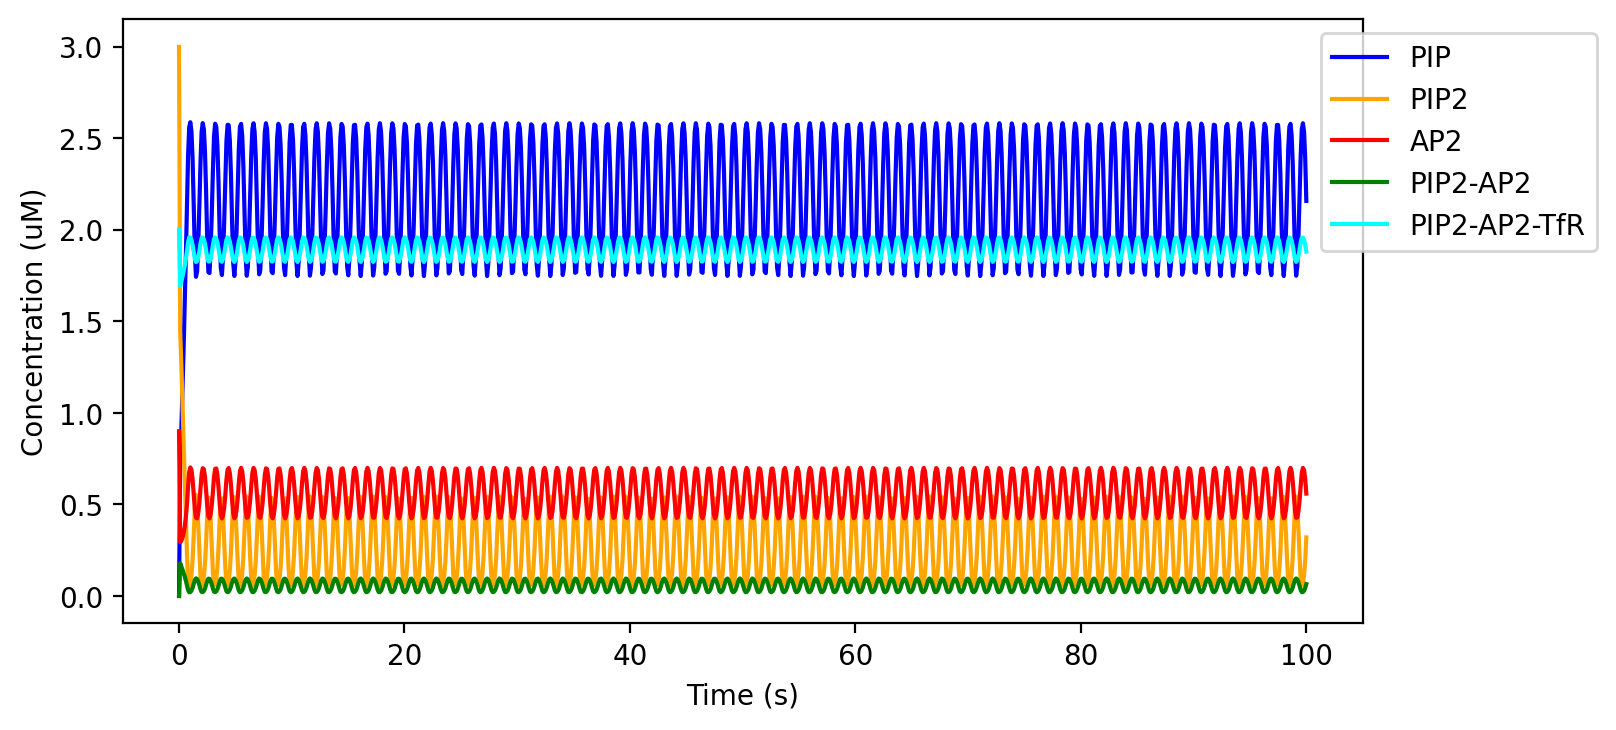

1


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


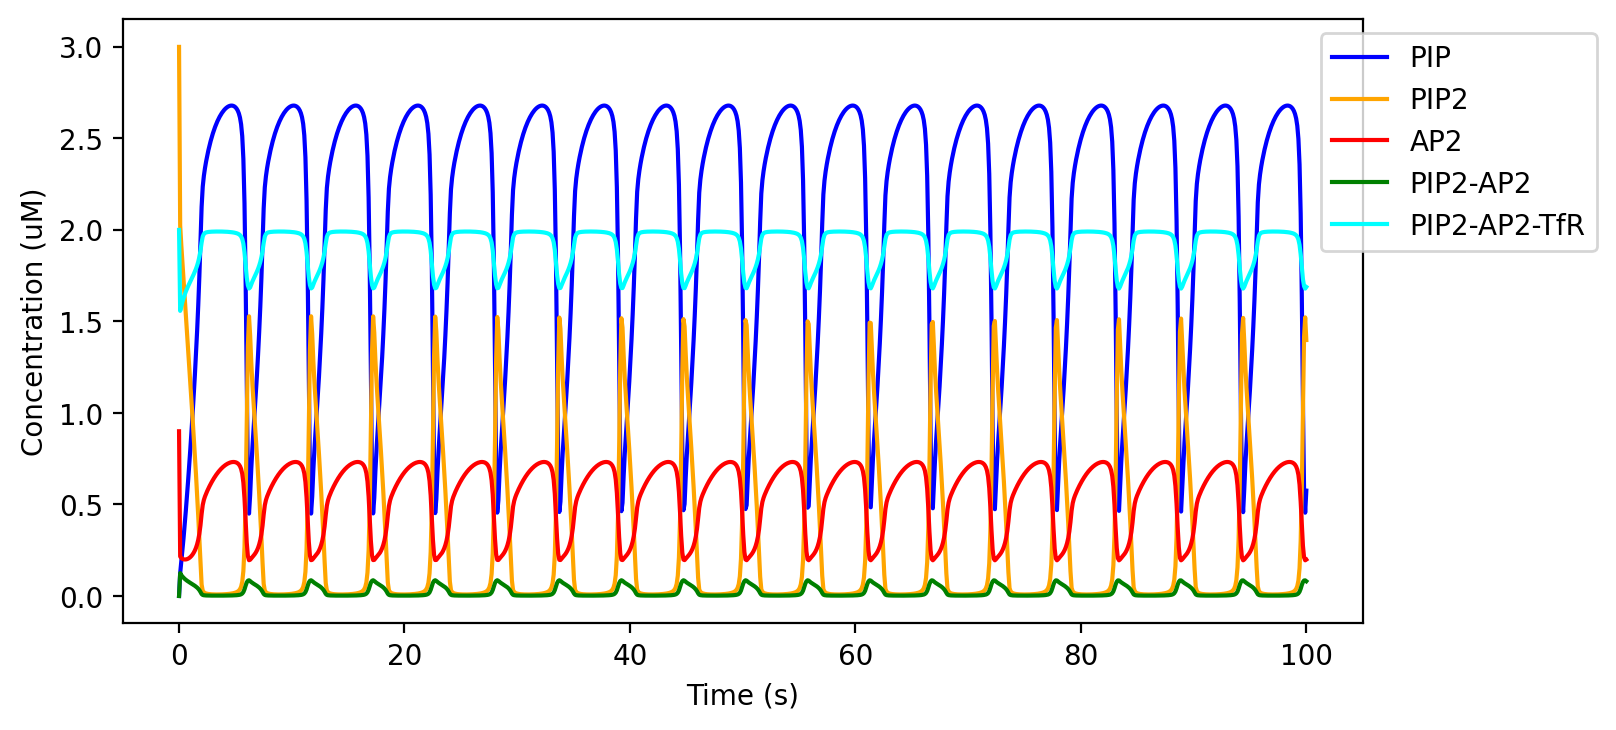

2


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


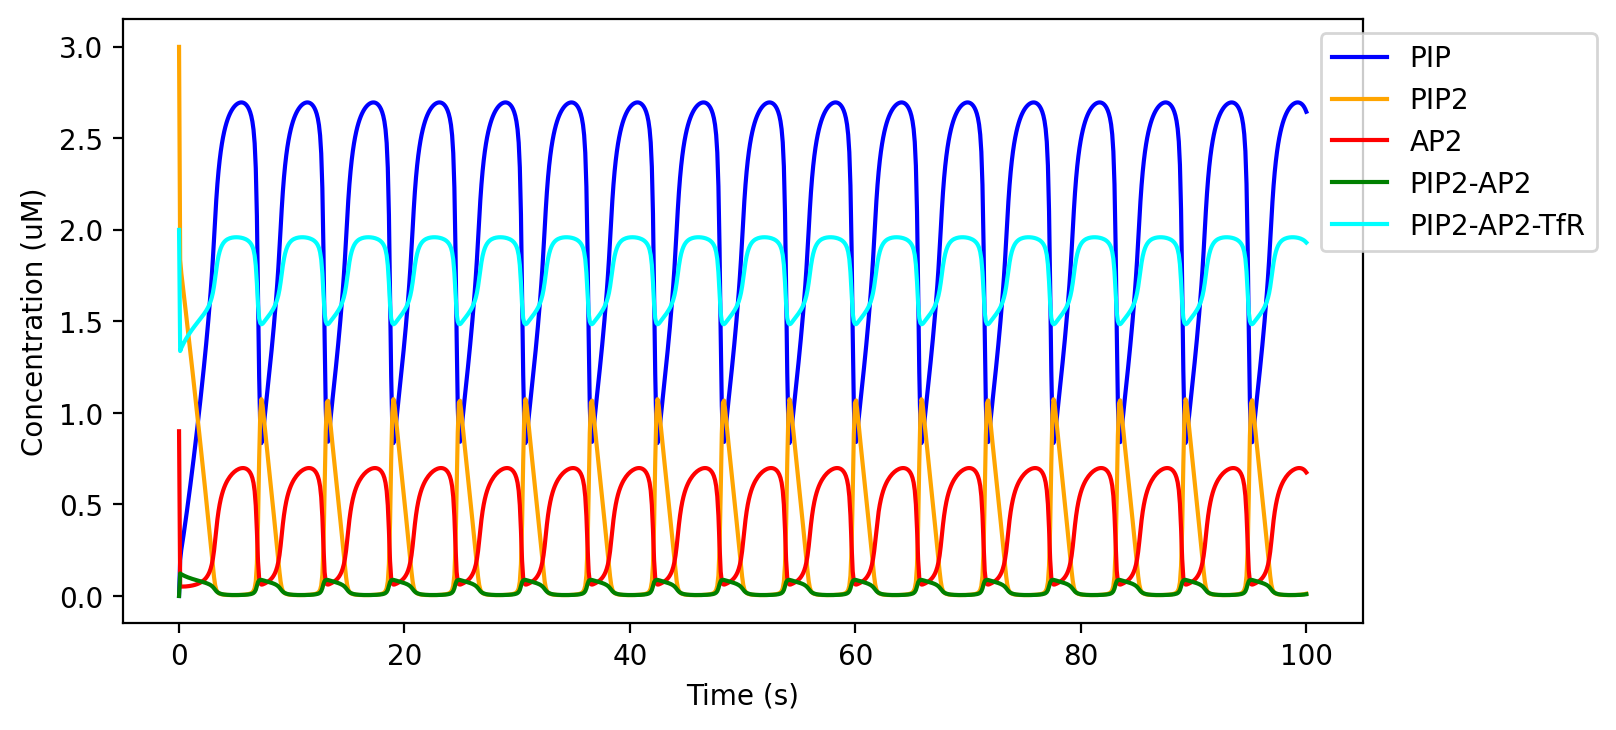

3


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


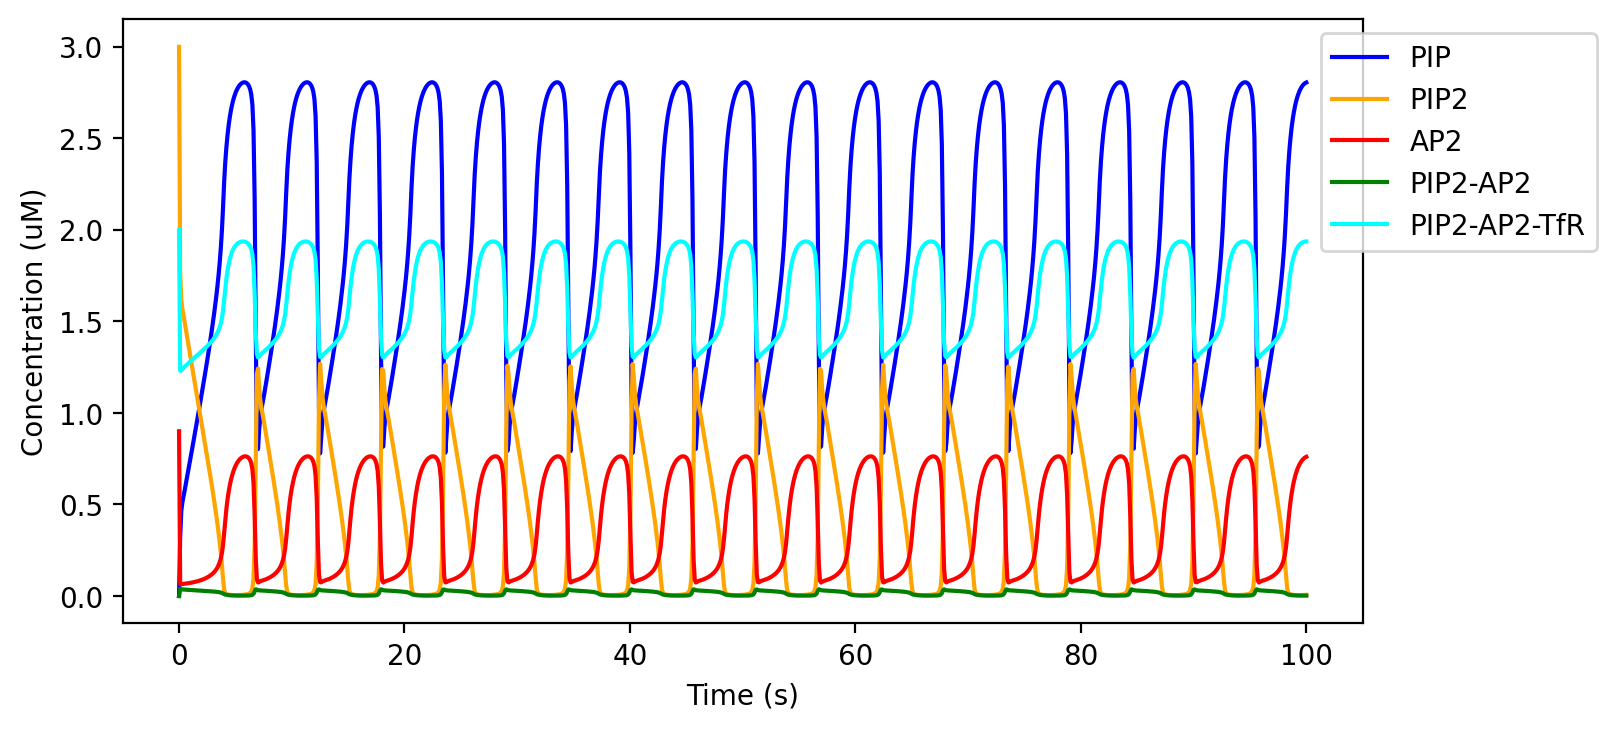

4


TypeError: can't unbox a <class 'numba.typed.typedlist.List'> as a <NULL>

In [7]:
filename =  os.path.join(".", "WithCargo")  
print(filename)  
model = Oscillator(IC_values, np.array(["ka1","kb1","kcat1","ka2","kb2","ka3","kb3","ka4","kb4","ka7","kb7","kcat7","VA","ka8","kb8"]), np.array([0,3,0.2,0.3,0,0.9,0,0,0,0,0,0,2,0]), mode=1)  #[0,3,0.2,0.3,0,0.9,0,0,0,0,0,0]
solver = Solver(model, name = 'WithCargo')         
solver.run(filename) 

# Load all viable points

In [102]:
allViablePoints = np.empty([1,13])
for filepath in glob.iglob('/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/8-16-22/smAllLp_*ViableSet_Iter10.p'):
    viablePoints = pickle.load(open(filepath,'rb'))
    allViablePoints = np.vstack((allViablePoints,viablePoints))


# Load one set of points

In [11]:
viablePoints = pickle.load(open('/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/10-28-22/ViableSets/smallkb_Region00000ViableSet_Iter10.p','rb'))

## Terrain plot

In [ ]:
def make_terrainplot(model,initials, test_species):
    viablePoints = pickle.load(open('./ViableSets/AllLp_Region000ViableSet_Iter10.p','rb'))
    params = viablePoints[random.uniform(0,len(viablePoints))]
    initials = initials
    for species in test_species:
        initials[species] = loguniform.rvs

    for i in range(10000):
        Lp = np.random.uniform(0,20)
        A = np.random.uniform(0,10)
        X = [0,Lp,0.6,0.8,0,A,0,0,0,0,0,0]
        Y[i][0] = Lp
        Y[i][1] = A
        Y[i][2] = model.eval_fixedinitials(X,params)[0]




In [ ]:
Y = np.zeros([10000,3])
params = viablePoints[0]

for i in range(10000):
    Lp = np.random.uniform(0,20)
    A = np.random.uniform(0,10)
    X = [0,Lp,0.6,0.8,0,A,0,0,0,0,0,0]
    Y[i][0] = Lp
    Y[i][1] = A
    Y[i][2] = model.eval_fixedinitials(X,params)[0]

In [ ]:
fig = plt.figure(figsize = (25,15))

#ax = fig.add_subplot(121, projection = '3d')

#ax.scatter(param_range[:,2], param_range[:,4], param_range[:,0], c = param_range[:,0],cmap='viridis', linewidth=0.5)

ax = fig.add_subplot(111, projection = '3d')

ax.plot_trisurf(Y[:,1], Y[:,0], Y[:,2],
                cmap='plasma', edgecolor='none');

#ax.set_title('Terrain of Parameter Space')
ax.set_xlabel('AP2 Concentration (uM)', fontsize = '20')
ax.set_ylabel('PIP2 Concentration (uM)', fontsize = '20')
ax.set_zlabel('Oscillation Index', fontsize = '20')

### Period and amplitude as function of AP2: line plot

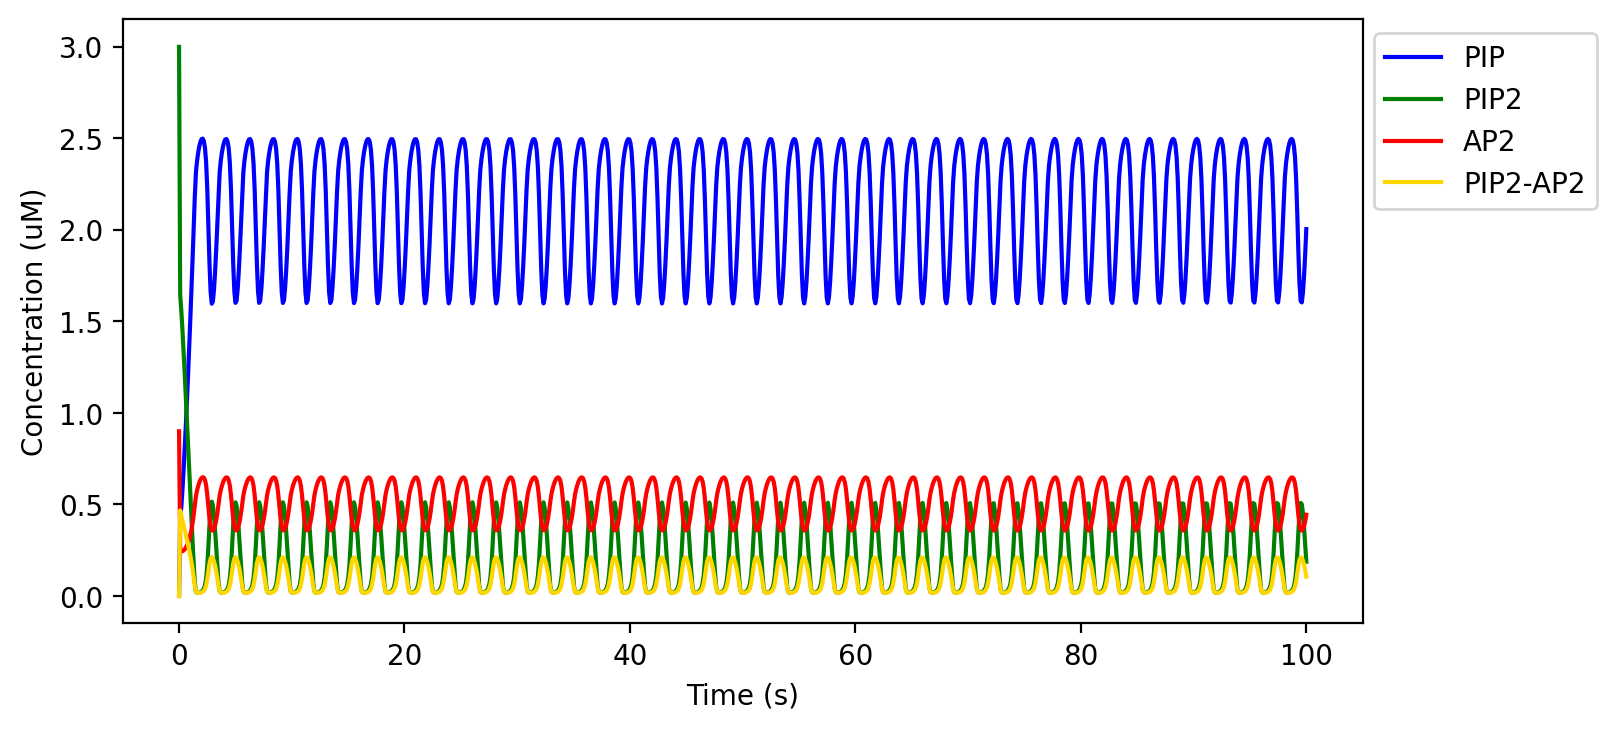

In [35]:
model.plotModel(viablePoints[3000])

In [38]:
datapoints = 1000

Yap2 = np.zeros([datapoints,3])
params = viablePoints[100]

ap2range = np.linspace(0.1,3,datapoints)

for i,val in enumerate(ap2range):
    Ap2 = val#np.random.uniform(0,10)
    # Lp = np.random.uniform(0,20)
    X = [0,3,0.05,0.05,0,Ap2,0,0,0,0,0,0]
    Yap2[i][0] = Ap2
    Yap2[i][1],Yap2[i][2] = model.getPerAmp(X,params)
    # Y[i][2] = model.eval_fixedinitials(X,params)[0]

Text(0.5, 0.98, 'Oscillation Period/Amplitude vs. AP2 Concentration, when initial Lp = 3 uM, using viablePoints[100]')

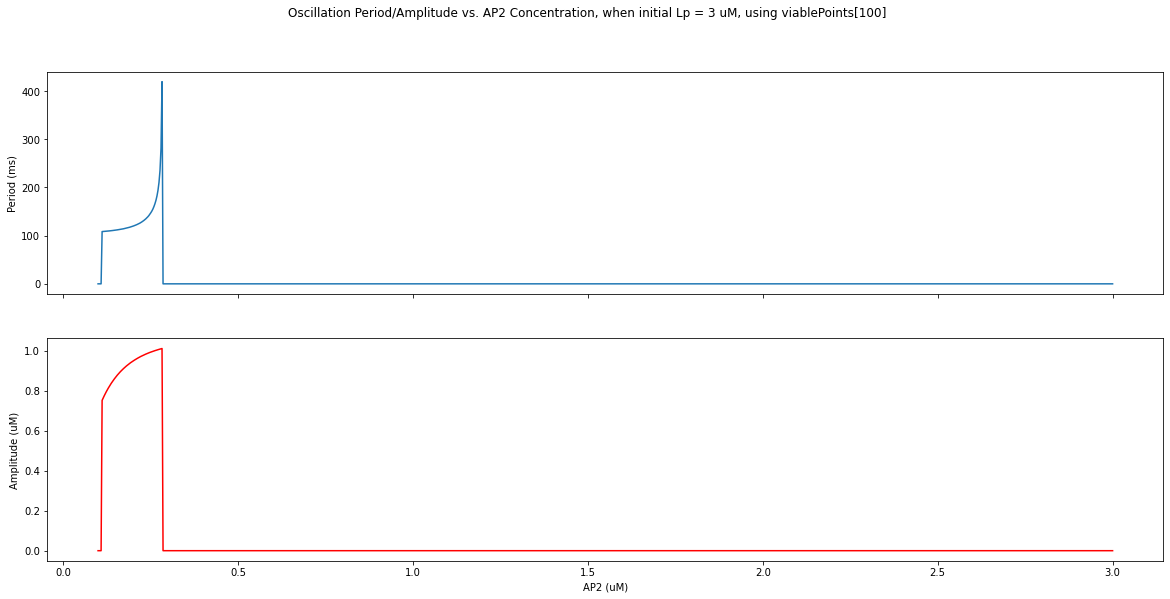

In [39]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (20,9), sharex=True)
ax1.plot(Yap2[:,0],Yap2[:,1]*1000)
ax1.set_ylabel("Period (ms)")

ax2.plot(Yap2[:,0],Yap2[:,2], color="r")
ax2.set_xlabel("AP2 (uM)")
ax2.set_ylabel("Amplitude (uM)")
fig.suptitle("Oscillation Period/Amplitude vs. AP2 Concentration, when initial Lp = 3 uM, using viablePoints[100]")

# Sensativity Analysis

## Sobol Method

In [97]:
problem = {
    'num_vars': 13,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA'],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[0,100],[0,1000],[0,500],[0,100],[0,1000],[0,100],[0,1000],[0,100],[0,1000],[0,100],[0,1000],[0,1000],[0,2]]
}


saltelli_samples = saltelli.sample(problem, 2**15)

In [93]:
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA']), np.array([0,9,0.6,0.8,0,2.7,0,0,0,0,0,0]), mode=1) 

In [89]:
Y = np.zeros([saltelli_samples.shape[0]])

for i,X in enumerate(saltelli_samples):
    Y[i] = model.eval(X)[0]

Si = sobol.analyze(problem, Y, print_to_console=True, parallel=True, n_processors=36)

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


             ST   ST_conf
ka1    0.412758  0.094165
kb1    0.336783  0.089429
kcat1  0.776290  0.144197
ka2    0.872949  0.179877
kb2    3.343027  0.573208
ka3    0.481962  0.094634
kb3    0.498957  0.106155
ka4    0.396597  0.096769
kb4    0.603601  0.142554
ka7    1.234979  0.235836
kb7    1.173461  0.222766
kcat7  0.506510  0.099865
VA     0.410424  0.096609
             S1   S1_conf
ka1    0.000738  0.006955
kb1    0.004996  0.010985
kcat1  0.030115  0.041095
ka2    0.033106  0.031629
kb2    0.013694  0.037331
ka3   -0.004184  0.003845
kb3   -0.002418  0.004231
ka4    0.001956  0.007499
kb4    0.014958  0.032453
ka7   -0.003895  0.007634
kb7    0.032907  0.050278
kcat7  0.000868  0.005937
VA     0.014956  0.022476
                    S2   S2_conf
(ka1, kb1)    0.002540  0.018043
(ka1, kcat1) -0.031352  0.040765
(ka1, ka2)   -0.028722  0.030928
(ka1, kb2)    0.010842  0.052139
(ka1, ka3)    0.021050  0.031062
...                ...       ...
(ka7, kcat7)  0.011732  0.022892
(ka7, VA

In [90]:
#plt.rcParams.update({})
total_Si, first_Si, second_Si = Si.to_df()

total_Si

,ST,ST_conf
ka1,0.412758,0.094165
kb1,0.336783,0.089429
kcat1,0.776290,0.144197
ka2,0.872949,0.179877
kb2,3.343027,0.573208
ka3,0.481962,0.094634
kb3,0.498957,0.106155
ka4,0.396597,0.096769
kb4,0.603601,0.142554
ka7,1.234979,0.235836


<AxesSubplot:>

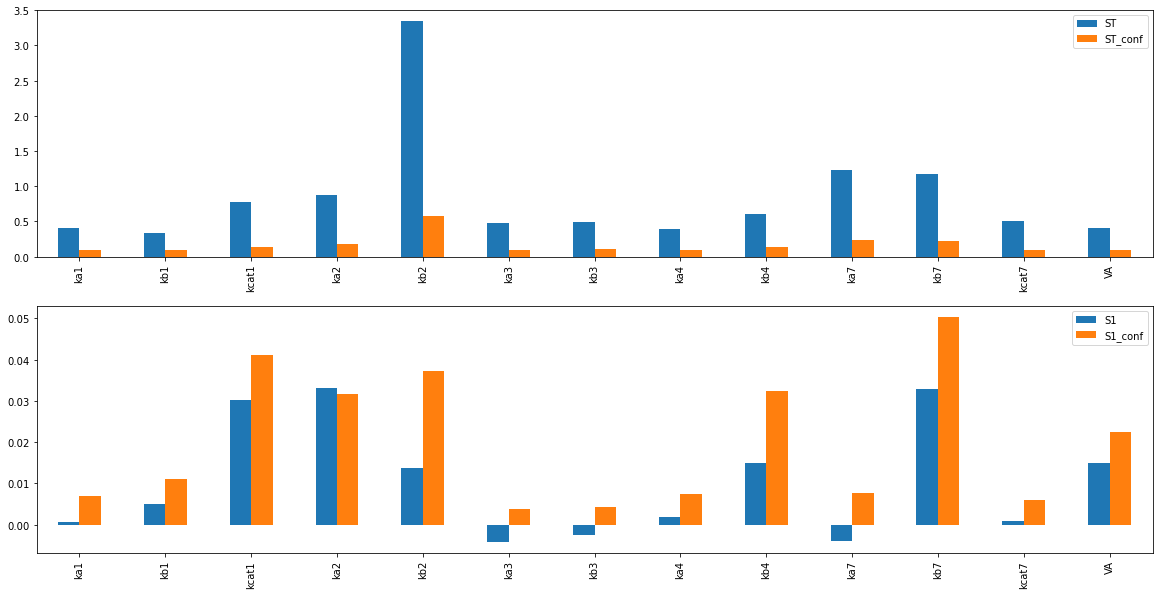

In [91]:
fig, axes = plt.subplots(2,1, figsize=(20,10))
total_Si.plot.bar(ax=axes[0])
first_Si.plot.bar(ax=axes[1])
#second_Si.plot.bar(ax=axes[0,1])

### Sobol eval on initial conditions 

In [94]:
problem = {
    'num_vars': 12,
    'names': ["L", "Lp", "K", "P", "LK", "A", "LpA", "LpAK","LpAP","LpAPLp","LpAKL","LpP"],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10]]
}

saltelli_samples = saltelli.sample(problem, 2**15)

In [112]:
saltelli_samples.shape

(917504, 13)

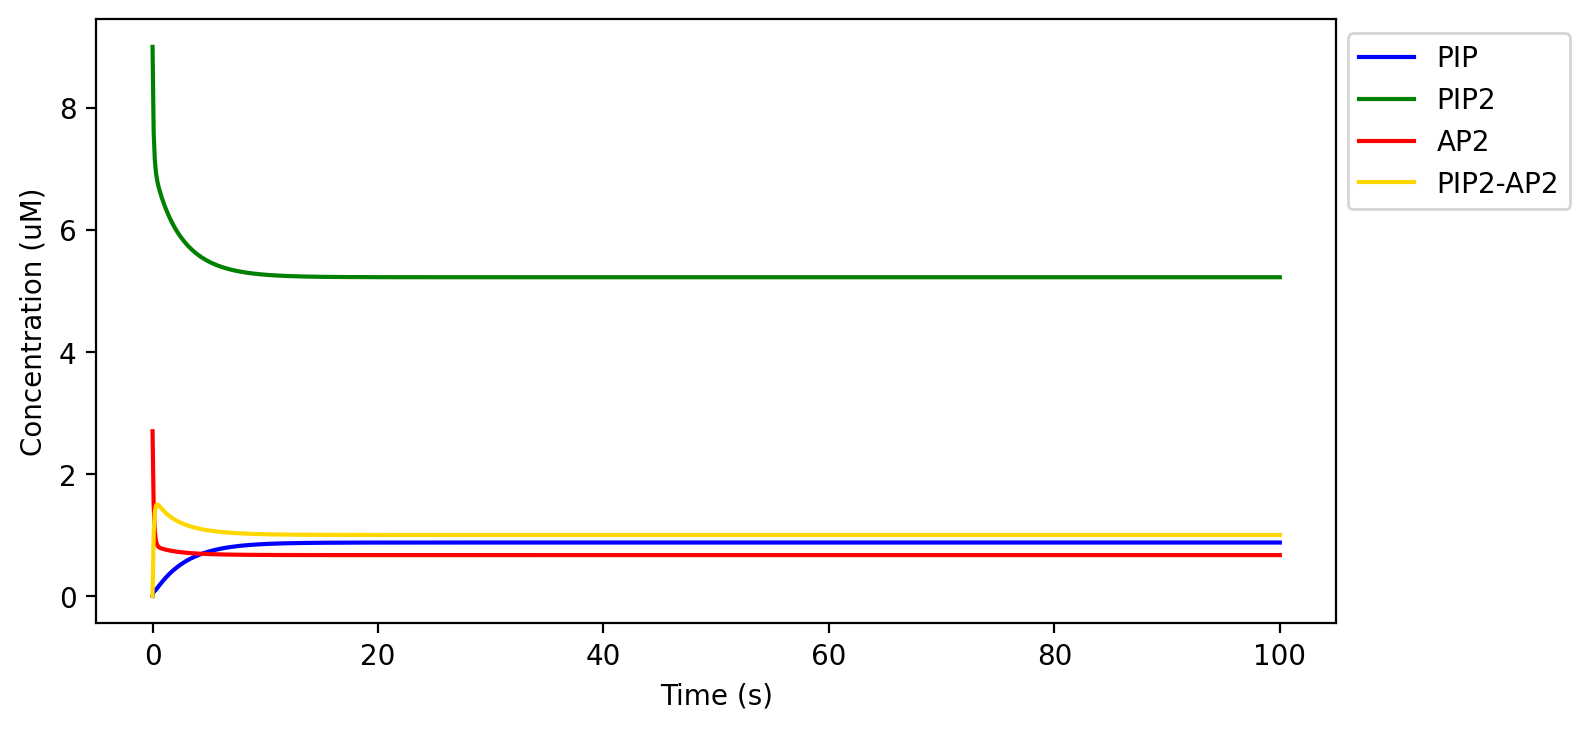

In [116]:
model.plotModel(viablePoints[1000])

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


              ST   ST_conf
L       0.511335  0.064486
Lp      0.533963  0.062251
K       0.745957  0.317675
P       0.622724  0.060454
LK      0.730716  0.107873
A       0.802769  0.078658
LpA     0.560873  0.062592
LpAK    0.664020  0.062929
LpAP    0.586027  0.063346
LpAPLp  0.364290  0.056400
LpAKL   0.726083  0.066066
LpP     0.588481  0.071378
              S1   S1_conf
L       0.001161  0.008570
Lp     -0.002557  0.006895
K      -0.000190  0.008264
P       0.013834  0.015572
LK      0.000549  0.009190
A       0.029728  0.014809
LpA     0.002806  0.009225
LpAK    0.005242  0.014064
LpAP    0.009657  0.011340
LpAPLp -0.000841  0.010232
LpAKL   0.001966  0.008999
LpP     0.006764  0.013821
                       S2   S2_conf
(L, Lp)          0.015120  0.016882
(L, K)           0.002793  0.012645
(L, P)           0.015528  0.021008
(L, LK)          0.002498  0.013630
(L, A)           0.013435  0.017881
...                   ...       ...
(LpAP, LpAKL)   -0.005416  0.015138
(LpAP, LpP

<AxesSubplot:>

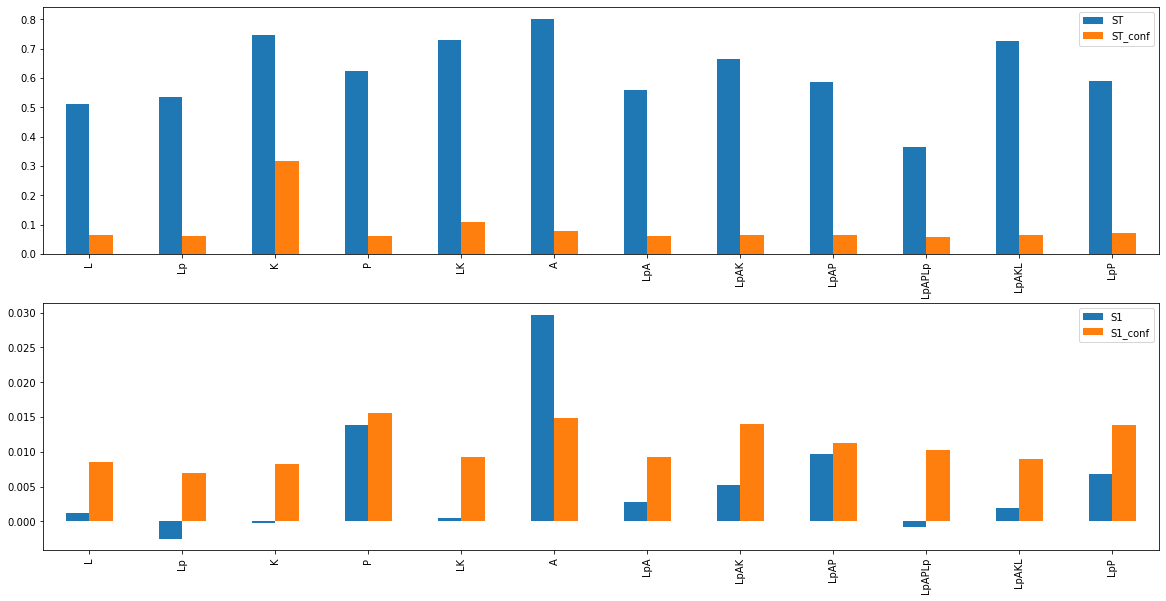

In [95]:
Y = np.zeros([saltelli_samples.shape[0]])
params = viablePoints[0]

for i,X in enumerate(saltelli_samples):
    Y[i] = model.eval_fixedinitials(X,params)[0]

Si = sobol.analyze(problem, Y, print_to_console=True, parallel=True, n_processors=36)

total_Si, first_Si, second_Si = Si.to_df()

fig, axes = plt.subplots(2,1, figsize=(20,10))
total_Si.plot.bar(ax=axes[0])
first_Si.plot.bar(ax=axes[1])

### Sobol with amplitude

In [10]:
problem = {
    'num_vars': 13,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA'],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[0,100],[0,1000],[0,500],[0,100],[0,1000],[0,100],[0,1000],[0,100],[0,1000],[0,100],[0,1000],[0,1000],[0,100]]
}


saltelli_samples = saltelli.sample(problem, 2**15) 

In [33]:
sampleinits = np.broadcast_to([0,3,0.2,0.3,0,0.9,0,0,0,0,0,0],(917504,12))

In [34]:
saltelli_samples = np.concatenate((saltelli_samples,sampleinits),axis=1)

In [16]:
test = viablePoints[1]

NameError: name 'viablePoints' is not defined

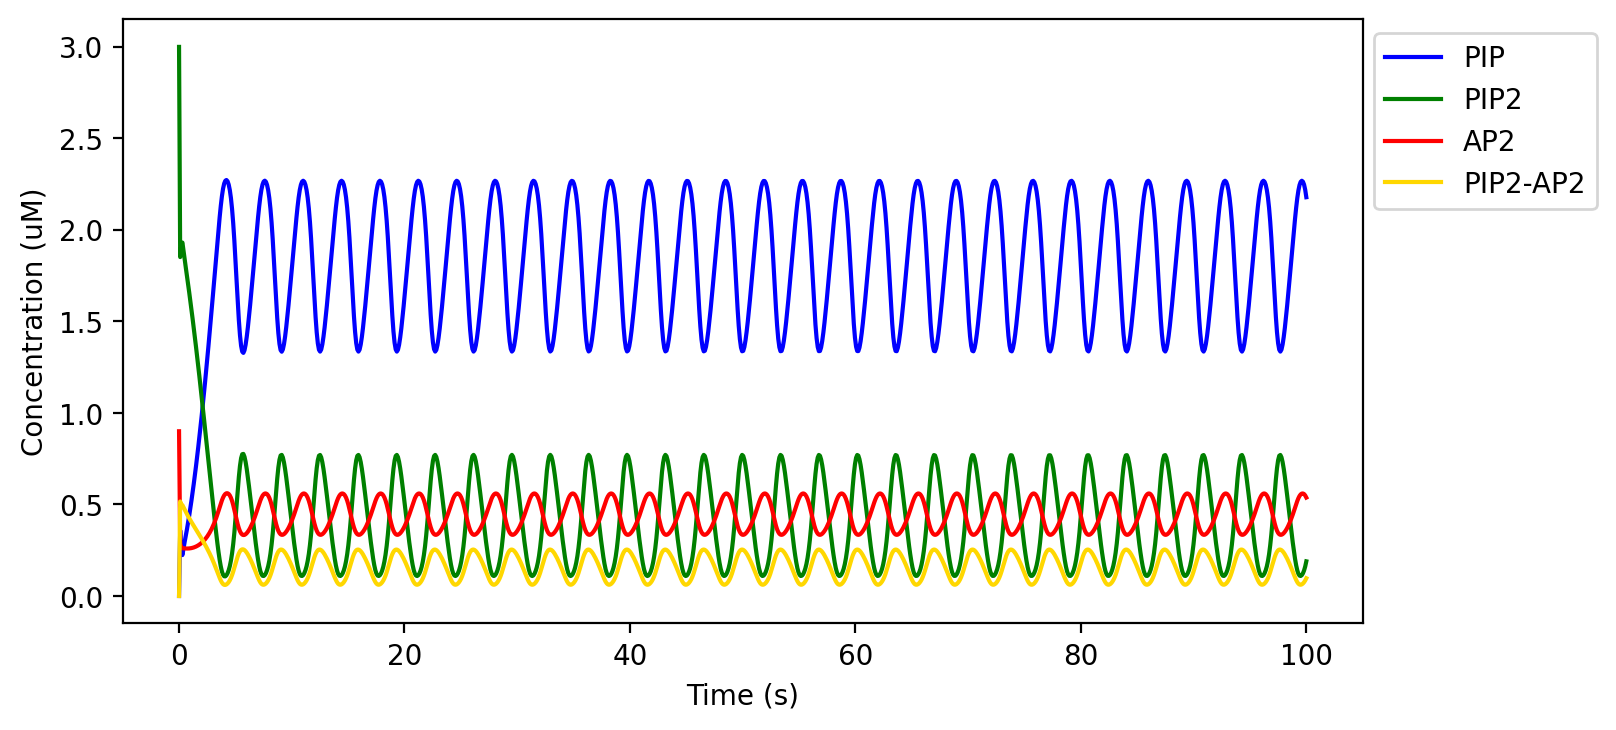

In [44]:
model.plotModel(test)

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0.5, 1.0, 'Amplitude Sensitivity Analysis with fixed initial conditions')

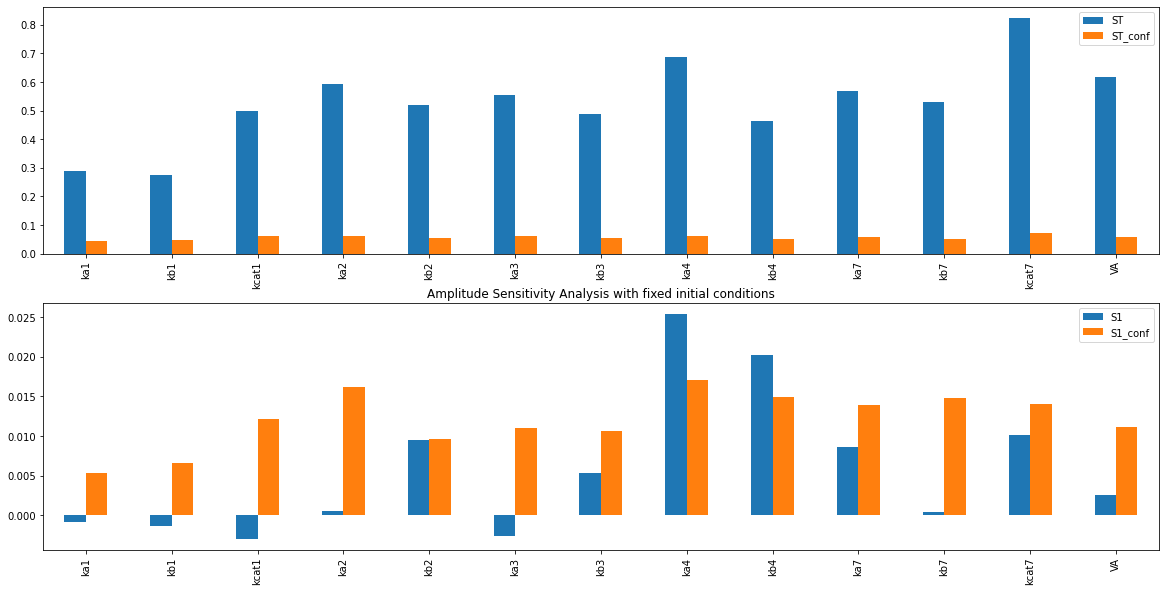

In [11]:
Y = np.zeros([saltelli_samples.shape[0]])

for i,X in enumerate(saltelli_samples):
    Y[i] = model.getPerAmp(X)[0]

Si = sobol.analyze(problem, Y, print_to_console=False, parallel=True,n_processors=36)

total_Si, first_Si, second_Si = Si.to_df()
fig, axes = plt.subplots(2,1, figsize=(20,10))
total_Si.plot.bar(ax=axes[0])
first_Si.plot.bar(ax=axes[1])
plt.title('Amplitude Sensitivity Analysis with fixed initial conditions')

### Sobol with period

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0.5, 1.0, 'Period Sensitivity Analysis with fixed initial conditions')

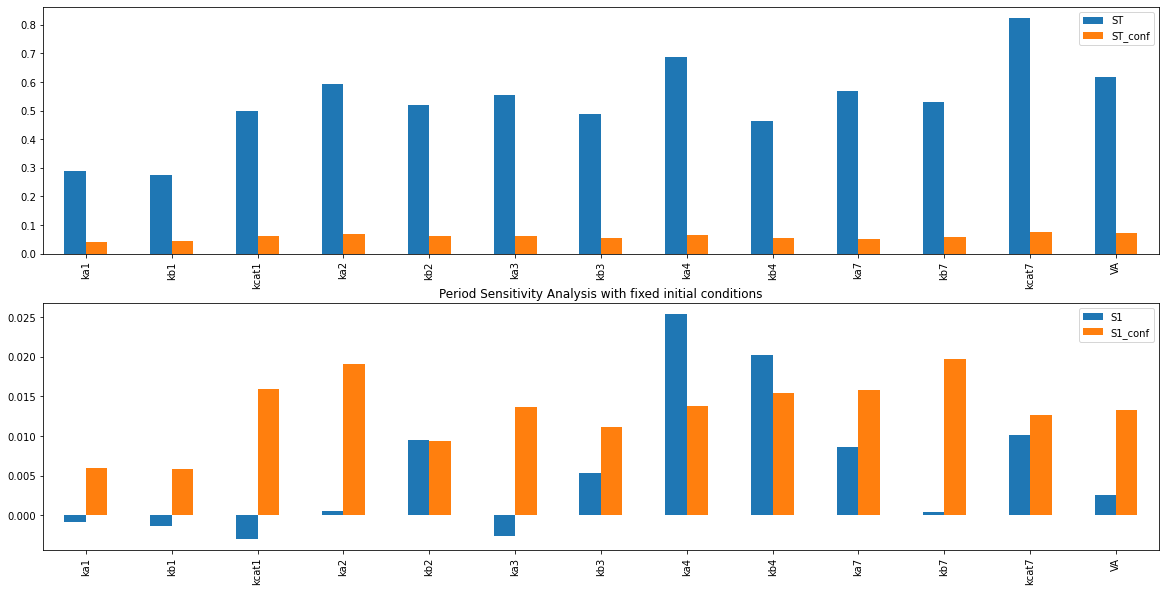

In [12]:
Yp = np.zeros([saltelli_samples.shape[0]])

for i,X in enumerate(saltelli_samples):
    Yp[i] = model.getPerAmp(X)[1]

Si_per = sobol.analyze(problem, Y, print_to_console=False, parallel=True,n_processors=36)

total_Si_per, first_Si_per, second_Si_per = Si_per.to_df()
fig, axes = plt.subplots(2,1, figsize=(20,10))
total_Si_per.plot.bar(ax=axes[0])
first_Si_per.plot.bar(ax=axes[1])
plt.title('Period Sensitivity Analysis with fixed initial conditions')

Period sensitivity to concentration

In [25]:
problem = {
    'num_vars': 12,
    'names': ["L", "Lp", "K", "P", "LK", "A", "LpA", "LpAK","LpAP","LpAPLp","LpAKL","LpP"],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10]]
}

saltelli_samples = saltelli.sample(problem, 2**15)

In [30]:
sample_param = viablePoints[1]

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0.5, 0.98, 'Period Sensitivity Analysis with fixed initial conditions')

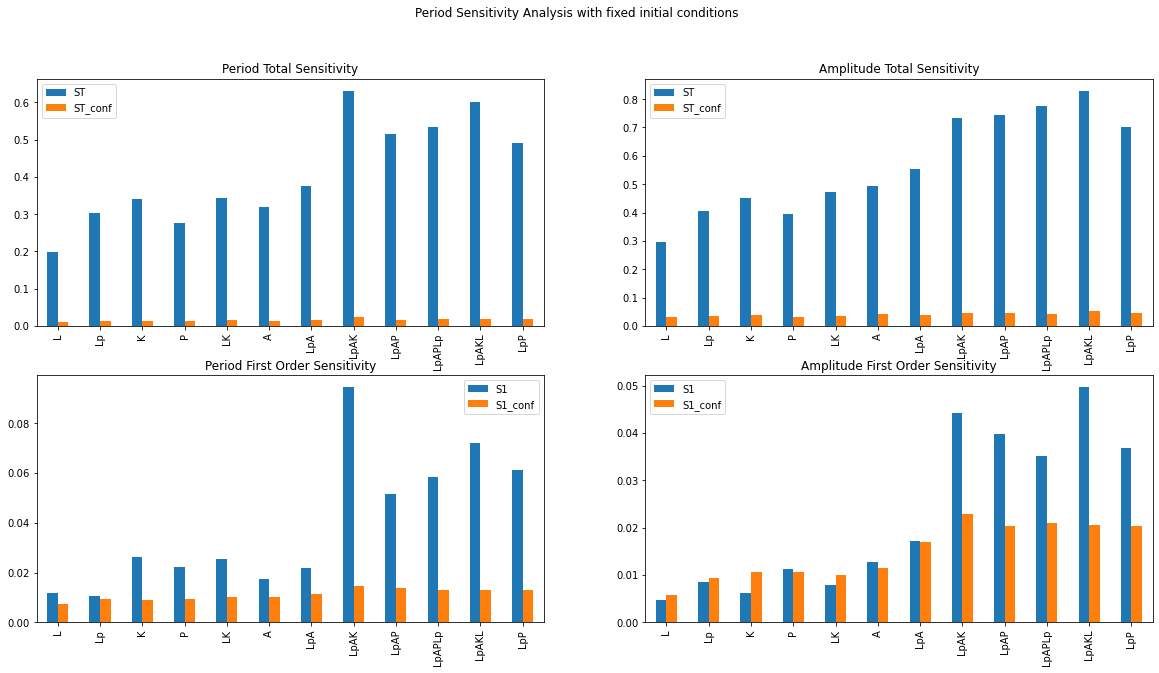

In [36]:
Yamp = np.zeros([saltelli_samples.shape[0]])
Yper = np.zeros([saltelli_samples.shape[0]])

for i,X in enumerate(saltelli_samples):
    Yamp[i],Yper[i] = model.getPerAmp(X,sample_param)

Si_amp = sobol.analyze(problem, Yamp, print_to_console=False, parallel=True,n_processors=36)
Si_per = sobol.analyze(problem, Yper, print_to_console=False, parallel=True,n_processors=36)

total_Si_amp, first_Si_amp, second_Si_amp = Si_amp.to_df()
total_Si_per, first_Si_per, second_Si_per = Si_per.to_df()
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(20,10))
total_Si_per.plot.bar(ax=ax1)
ax1.set_title("Period Total Sensitivity")
total_Si_amp.plot.bar(ax=ax2)
ax2.set_title("Amplitude Total Sensitivity")


first_Si_per.plot.bar(ax=ax3)
ax3.set_title("Period First Order Sensitivity")
first_Si_amp.plot.bar(ax=ax4)
ax4.set_title("Amplitude First Order Sensitivity")


plt.suptitle('Period Sensitivity Analysis with fixed initial conditions')

## Parametric relationships

In [ ]:
import collections

kadic_counts = [[] for i in range(5)]
kbdic_counts = [[] for i in range(5)]
kcatdic_counts = [[] for i in range(2)]
KDdic_counts = [[] for i in range(5)]
counts = [kadic_counts, kbdic_counts, kcatdic_counts, KDdic_counts]

for rdm_ind in allViablePoints:

    kadic = {'ka1':rdm_ind[0],'ka2':rdm_ind[3],'ka3':rdm_ind[5],'ka4':rdm_ind[7],'ka7':rdm_ind[9]}
    kbdic = {'kb1':rdm_ind[1],'kb2':rdm_ind[4],'kb3':rdm_ind[6],'kb4':rdm_ind[8],'kb7':rdm_ind[10]}
    kcatdic = {'kcat1':rdm_ind[2],'kcat7':rdm_ind[11]}
    KDdic = {'Km1':(rdm_ind[1]+rdm_ind[2])/rdm_ind[0],'Kd2':rdm_ind[4]/rdm_ind[3],'Kd3':rdm_ind[6]/rdm_ind[5],'Kd4':rdm_ind[8]/rdm_ind[7],'Km7':(rdm_ind[10]+rdm_ind[11])/rdm_ind[9]}
    comparison_list = [kadic,kbdic,kcatdic,KDdic]

    for i,h in enumerate(comparison_list):
        sorted_keys = sorted(h, key=h.get)  # [1, 3, 2]
        for j,key in enumerate(sorted_keys):
            counts[i][j].append(key)

for list in counts:
    string = ""
    for par in list:
        freqs = collections.Counter(par)
        most_freq = freqs.most_common(1)[0][0]
        string += most_freq + " < "
    print(string)

## Violin plots

In [12]:
points = viablePoints

In [13]:
only_params = points[:,:11]
only_params[1].size

11

In [14]:
only_params = points[:,:12]
#Km1 = only_params[:,1]+only_params[:,2]/only_params[:,0]
#only_params = np.insert(only_params, 1, Km1, axis=1)
Km1 = only_params[:,1]+only_params[:,2]/only_params[:,0]
Kd2 = only_params[:,4]/only_params[:,3]
Kd3 = only_params[:,6]/only_params[:,5]
Kd4 = only_params[:,8]/only_params[:,7]
Km7 = only_params[:,10]+only_params[:,11]/only_params[:,9]
only_params = np.column_stack((only_params,Km1,Kd2,Kd3,Kd4,Km7))
only_params.shape

(5325, 17)

In [13]:
np.column_stack((only_params, Km1,Kd2,Kd3,Kd4,Km7)).shape

(2226, 22)

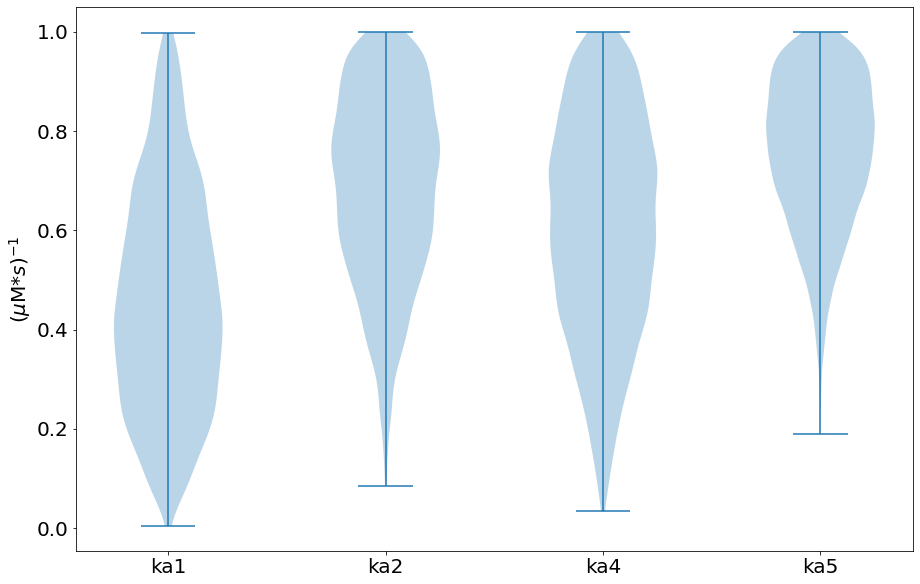

In [22]:
kalist = [only_params[:,0], only_params[:,3], only_params[:,7], only_params[:,9]]
plt.figure(figsize=(15,10))
plt.violinplot(kalist)
plt.xticks([1,2,3,4], ['ka1','ka2','ka4','ka5'], fontsize = '20')
plt.ylabel(r'($\mu$'+'M'+'$*s)^{-1}$', fontsize = 20)
plt.yticks(fontsize = '20')
plt.show()


Text(0, 0.5, '$s^{-1}$')

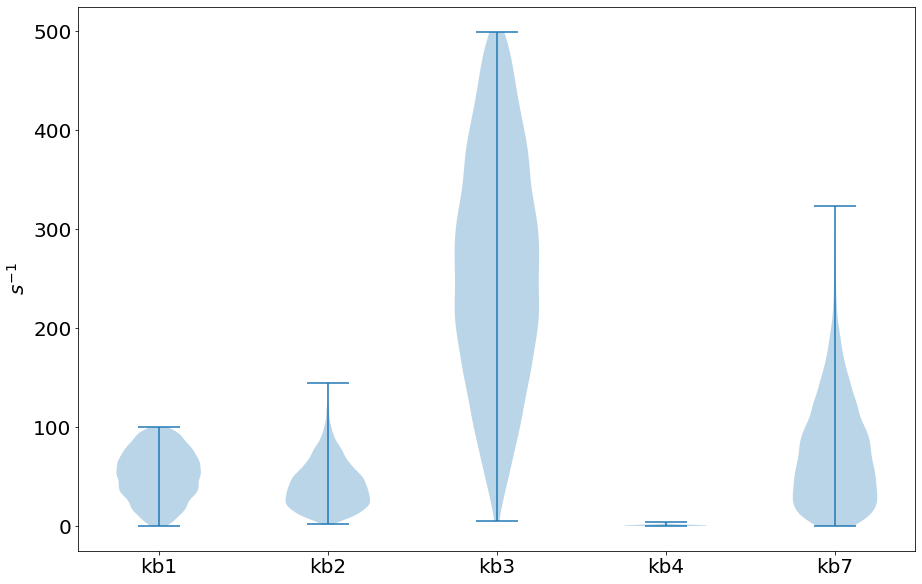

In [23]:
kblist = [only_params[:,1], only_params[:,4], only_params[:,6], only_params[:,8], only_params[:,10]]
plt.figure(figsize=(15,10))
plt.violinplot(kblist)
plt.xticks([1,2,3,4,5], ['kb1','kb2','kb3','kb4', 'kb7'], fontsize = '20')
plt.yticks(fontsize = '20')
plt.ylabel('$s^{-1}$', fontsize = '20')



Text(0, 0.5, '$s^{-1}$')

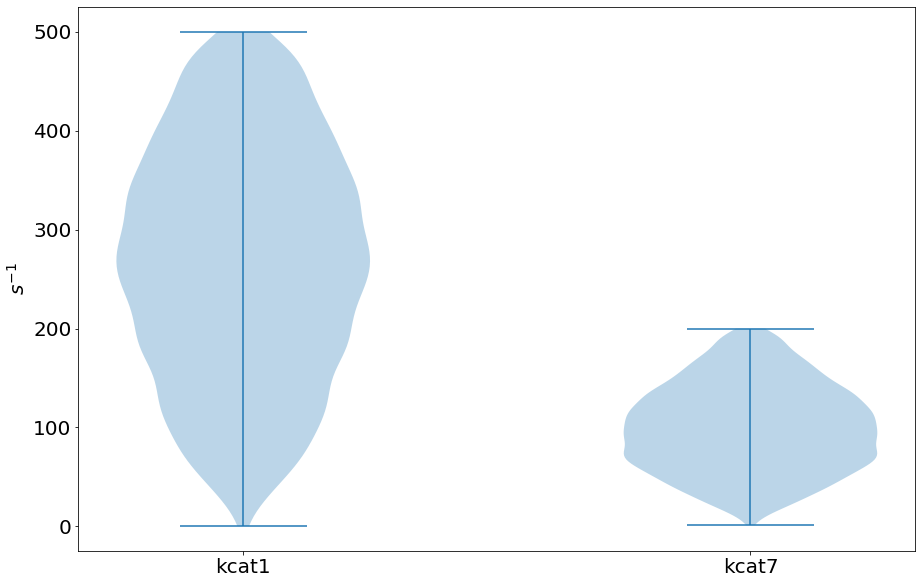

In [24]:
kcatlist = [only_params[:,2], only_params[:,11]]
plt.figure(figsize=(15,10))
plt.violinplot(kcatlist)
plt.xticks([1,2], ['kcat1','kcat7'], fontsize = '20')
plt.yticks(fontsize = '20')
plt.ylabel('$s^{-1}$', fontsize = '20')

Text(0, 0.5, '$\\mu$M')

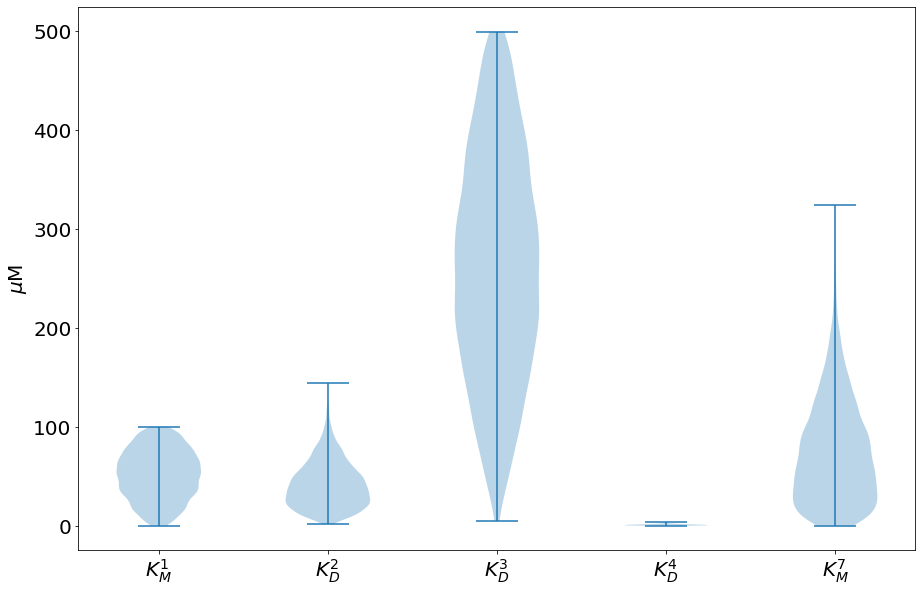

In [30]:
Kdlist = [(only_params[:,1]+only_params[:,2])/only_params[:,0], only_params[:,4]/only_params[:,3],only_params[:,6]/only_params[:,5], only_params[:,8]/only_params[:,7], (only_params[:,10]+only_params[:,11])/only_params[:,9]]
plt.figure(figsize=(15,10))
plt.violinplot(kblist)
plt.xticks([1,2,3,4,5], [r'$K_M^1$',r'$K_D^2$',r'$K_D^3$',r'$K_D^4$', r'$K_M^7$'],fontsize = '20')
plt.yticks(fontsize = '20')
plt.ylabel(r'$\mu$'+'M',fontsize = '20')

In [79]:
def prep_boxplot(region):
    points = np.array(region.points)
    only_params = points[:,:11]
    Km1 = only_params[:,1]+only_params[:,2]/only_params[:,0]
    Kd2 = only_params[:,4]/only_params[:,3]
    Kd3 = only_params[:,6]/only_params[:,5]
    Kd4 = only_params[:,8]/only_params[:,7]
    Km7 = only_params[:,10]+only_params[:,11]/only_params[:,9]
    only_params = np.column_stack((only_params,Km1,Kd2,Kd3,Kd4,Km7))

    return only_params
